In [ ]:
# !pip install yfinance

In [ ]:
# pwd

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

stock_filepath = os.getenv('HOME') +'/aiffel/aiffel_quest/mini_quest_240229/data/'
df = pd.read_csv(stock_filepath + '005930.KS.csv')

df.head()

Date     Open     High      Low    Close     Adj Close    Volume
0  2020-05-18  47950.0  49100.0  47600.0  48800.0  46788.835938  20481981
1  2020-05-19  50100.0  50500.0  49700.0  50300.0  48227.015625  25168295
2  2020-05-20  50000.0  50200.0  49800.0  50000.0  47939.382813  14896899
3  2020-05-21  50300.0  50400.0  49850.0  49950.0  47891.437500  14949266
4  2020-05-22  49600.0  49800.0  48600.0  48750.0  46740.894531  19706284

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       250 non-null    object 
 1   Open       250 non-null    float64
 2   High       250 non-null    float64
 3   Low        250 non-null    float64
 4   Close      250 non-null    float64
 5   Adj Close  250 non-null    float64
 6   Volume     250 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 13.8+ KB


In [4]:
df = pd.read_csv(stock_filepath + '005930.KS.csv', index_col='Date', parse_dates=True)

ts_close =df['Close']
ts_close.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

### 시계열 안정성 정성적 분석

In [6]:
ts_close = ts_close.interpolate(method='time')
ts_close[ts_close.isna()]

Series([], Name: Close, dtype: float64)

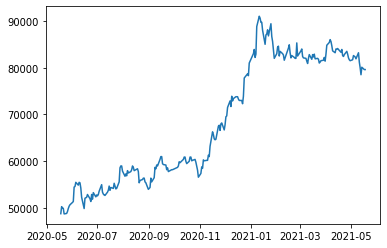

In [7]:
plt.plot(ts_close)

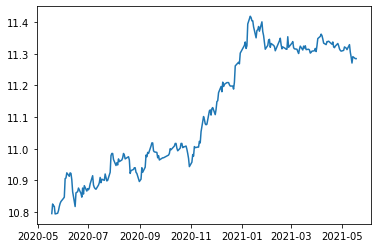

In [8]:
ts_log = np.log(ts_close)
plt.plot(ts_log)

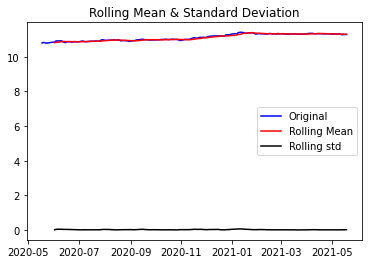

Results of Dickey=Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


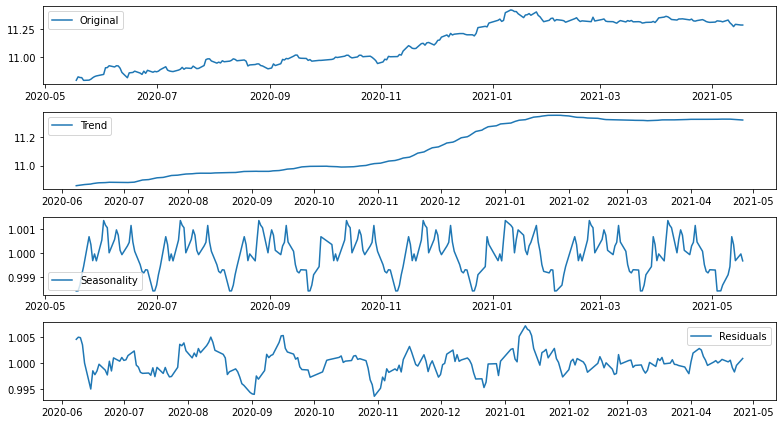

In [9]:
# 정성적 그래프 분석
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()
    
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)



from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    
    print('Results of Dickey=Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 


plt.rcParams['figure.figsize'] = (11,6)


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

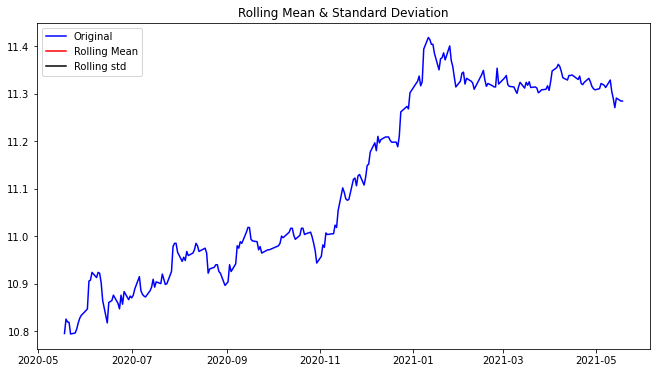

In [10]:
plot_rolling_statistics(ts_log, window=365)

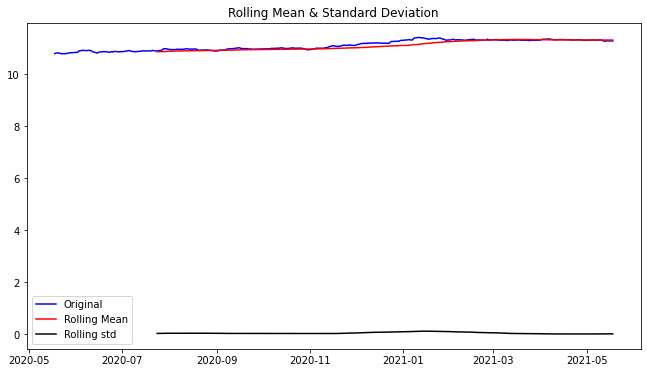

In [11]:
plot_rolling_statistics(ts_log, window=50)

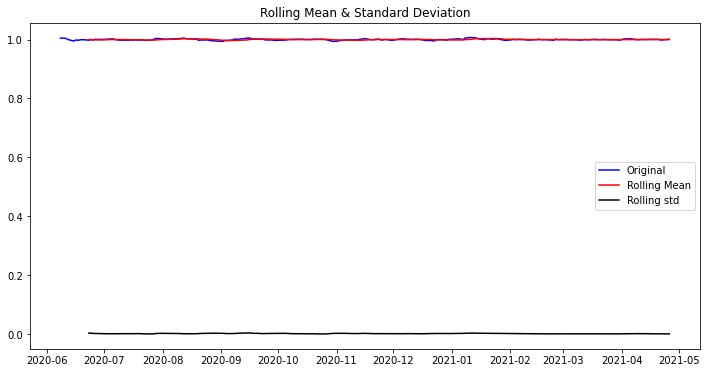

In [12]:
# Residual 안정성 확인
residual.dropna(inplace=True)
plt.rcParams['figure.figsize'] = (12, 6)
plot_rolling_statistics(residual)

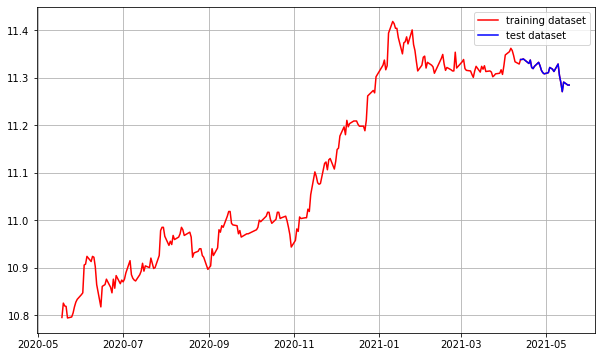

In [13]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

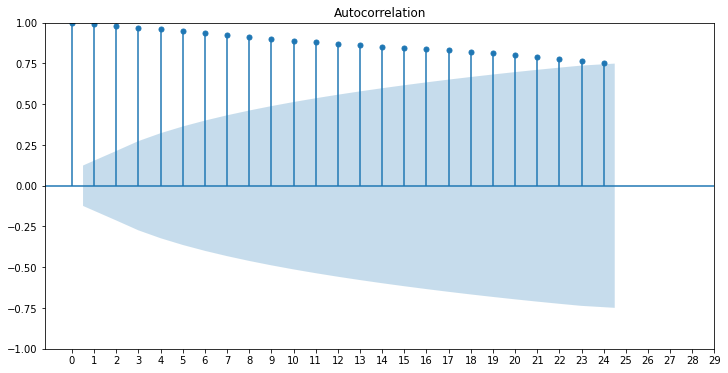

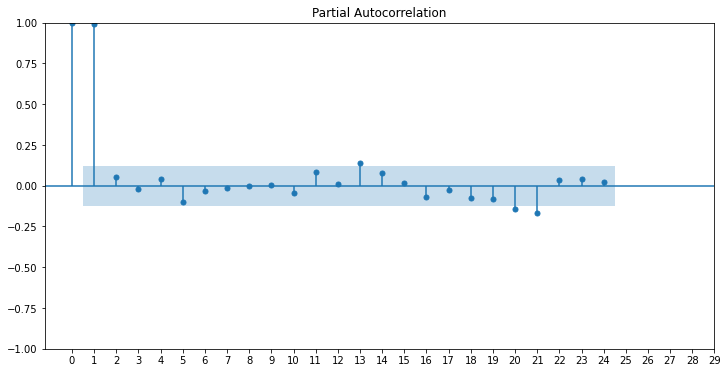

In [14]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plot_acf(ts_log)
plt.xticks(range(0, 30, 1))
plot_pacf(ts_log)
plt.xticks(range(0, 30, 1))
plt.show()

Results of Dickey=Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey=Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


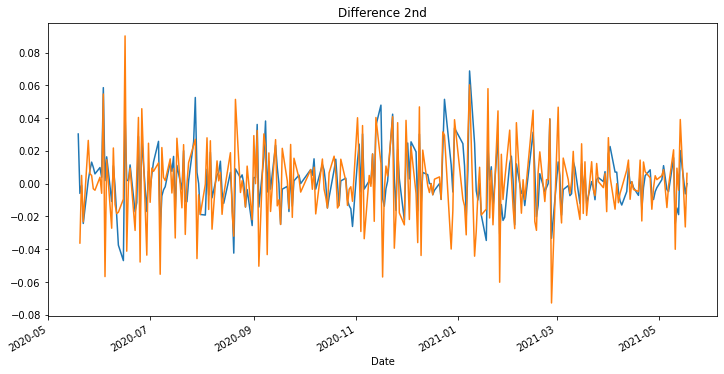

In [15]:
# 차분 안정성 확인 -> d 구하기

diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)


# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### 추세 상쇄하기

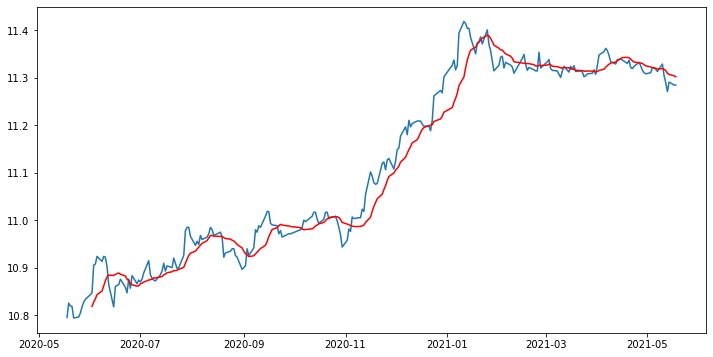

In [16]:
moving_avg = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [17]:
ts_log_moving_avg = ts_log - moving_avg
ts_log_moving_avg.head(20)

Date
2020-05-18         NaN
2020-05-19         NaN
2020-05-20         NaN
2020-05-21         NaN
2020-05-22         NaN
2020-05-25         NaN
2020-05-26         NaN
2020-05-27         NaN
2020-05-28         NaN
2020-05-29         NaN
2020-06-01         NaN
2020-06-02    0.028599
2020-06-03    0.077956
2020-06-04    0.072953
2020-06-05    0.080606
2020-06-08    0.061862
2020-06-09    0.061925
2020-06-10    0.049636
2020-06-11    0.021446
2020-06-12   -0.019996
Name: Close, dtype: float64

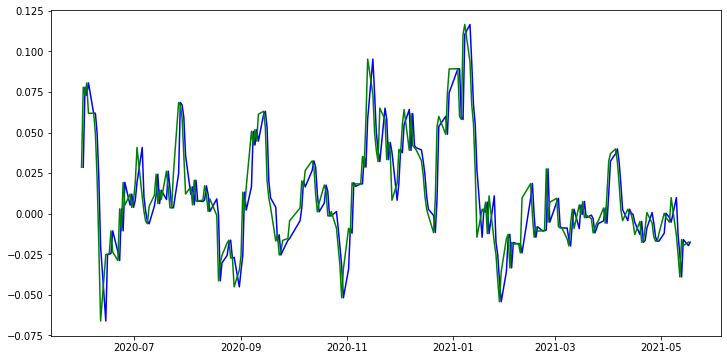

In [18]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift(-1)


plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

In [19]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(20)

Date
2020-06-02    0.028599
2020-06-03    0.077956
2020-06-04    0.072953
2020-06-05    0.080606
2020-06-08    0.061862
2020-06-09    0.061925
2020-06-10    0.049636
2020-06-11    0.021446
2020-06-12   -0.019996
2020-06-15   -0.066141
2020-06-16   -0.025267
2020-06-17   -0.024961
2020-06-18   -0.024494
2020-06-19   -0.010603
2020-06-22   -0.023697
2020-06-23   -0.028907
2020-06-24    0.002950
2020-06-25   -0.010546
2020-06-26    0.019292
2020-06-29    0.005231
Name: Close, dtype: float64

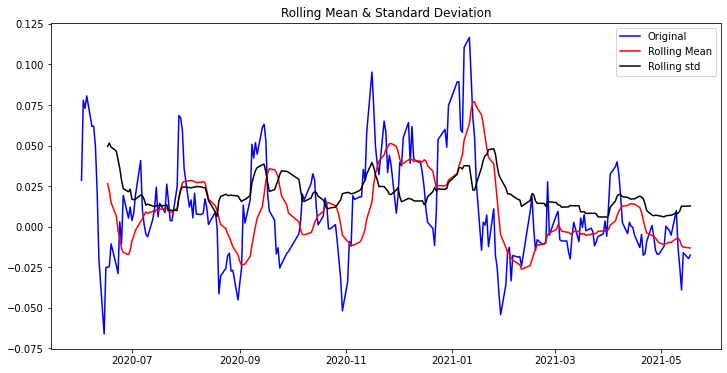

In [20]:
plot_rolling_statistics(ts_log_moving_avg)

In [21]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey=Fuller Test:
Test Statistic                  -4.163469
p-value                          0.000759
#Lags Used                       0.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64


In [22]:
moving_avg_6 = ts_log.rolling(window=6).mean()
ts_log_moving_avg_6 = ts_log - moving_avg_6
ts_log_moving_avg_6.dropna(inplace=True)

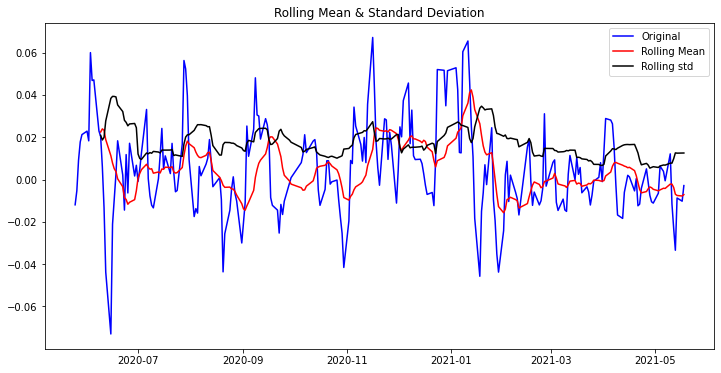

In [23]:
plot_rolling_statistics(ts_log_moving_avg_6)

In [24]:
augmented_dickey_fuller_test(ts_log_moving_avg_6)

Results of Dickey=Fuller Test:
Test Statistic                  -4.800754
p-value                          0.000054
#Lags Used                       5.000000
Number of Observations Used    239.000000
Critical Value (1%)             -3.458011
Critical Value (5%)             -2.873710
Critical Value (10%)            -2.573256
dtype: float64


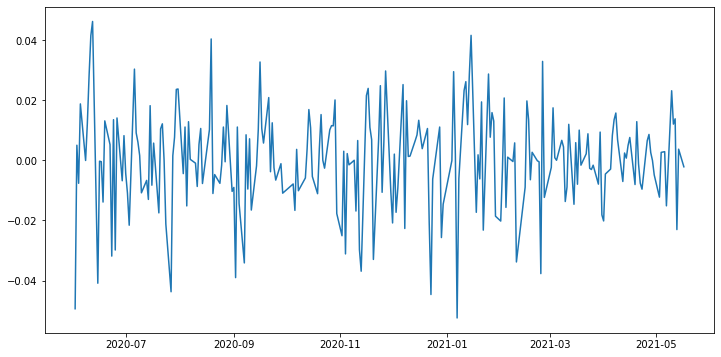

In [25]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

In [26]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Sun, 03 Mar 2024   AIC                          -1156.722
Time:                        16:23:18   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

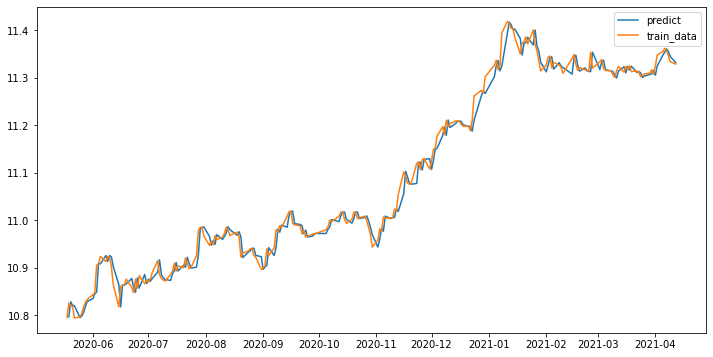

In [27]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given

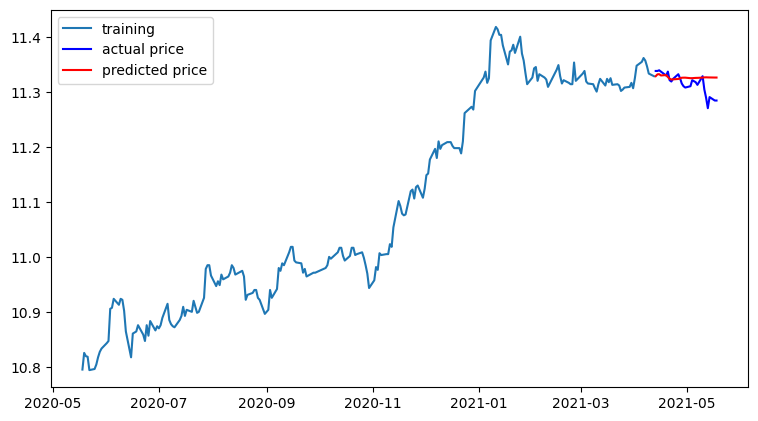

In [28]:
model = ARIMA(train_data, order=(14,1,0))
fitted_m = model.fit()
fc = fitted_m.forecast(len(test_data), alpha=0.5) # 95% conf
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(9, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3005069.905300547
MAE:  1233.7924909538601
RMSE:  1733.5137453451434
MAPE: 1.53%


### 삼성주가_최근 주가 포함 

In [18]:
import yfinance as yf

# 삼성전자 주식 데이터 불러오기
samsung_electronics = yf.Ticker('005930.KS')  # '005930.KS'는 삼성전자의 종목 코드입니다. '.KS'는 한국 시장을 의미합니다.

# 시작일과 종료일 설정 (2020년 1월 1일부터 2024년 1월 31일까지)
start_date = '2000-01-01'
end_date = '2024-02-27'

# 데이터 가져오기 (과거부터 오늘까지의 데이터)
samsung_data = samsung_electronics.history(start=start_date, end=end_date)


# 날짜 형식 변경 및 인덱스 설정
# samsung_data.index = pd.to_datetime(samsung_data.index).strftime('%Y-%m-%d')

# 데이터프레임 생성
df = pd.DataFrame(samsung_data,  columns=samsung_data.columns)

df


Open          High           Low  \
Date                                                                  
2000-01-04 00:00:00+09:00   4389.457760   4469.931152   4140.721820   
2000-01-05 00:00:00+09:00   4243.143604   4433.353489   4038.302188   
2000-01-06 00:00:00+09:00   4206.562409   4228.509691   4082.194477   
2000-01-07 00:00:00+09:00   4067.563408   4148.036785   3921.248177   
2000-01-10 00:00:00+09:00   4096.828287   4221.196289   4082.196758   
...                                 ...           ...           ...   
2024-02-20 00:00:00+09:00  73700.000000  73700.000000  72800.000000   
2024-02-21 00:00:00+09:00  73400.000000  73700.000000  72900.000000   
2024-02-22 00:00:00+09:00  73800.000000  73900.000000  72700.000000   
2024-02-23 00:00:00+09:00  73600.000000  74200.000000  72900.000000   
2024-02-26 00:00:00+09:00  72300.000000  73200.000000  72200.000000   

                                  Close    Volume  Dividends  Stock Splits  
Date                                                                        
2000-01-04 00:00:00+09:00   4469.931152  74195000        0.0           0.0  
2000-01-05 00:00:00+09:00   4082.196777  74680000        0.0           0.0  
2000-01-06 00:00:00+09:00   4111.457520  54390000        0.0           0.0  
2000-01-07 00:00:00+09:00   4052.931885  40305000        0.0           0.0  
2000-01-10 00:00:00+09:00   4221.196289  46880000        0.0           0.0  
...                                 ...       ...        ...           ...  
2024-02-20 00:00:00+09:00  73300.000000  14681477        0.0           0.0  
2024-02-21 00:00:00+09:00  73000.000000  11503495        0.0           0.0  
2024-02-22 00:00:00+09:00  73100.000000  15208934        0.0           0.0  
2024-02-23 00:00:00+09:00  72900.000000  16225166        0.0           0.0  
2024-02-26 00:00:00+09:00  72800.000000  14669352        0.0           0.0  

[6055 rows x 7 columns]

In [19]:
ts = df['Close']
ts

Date
2000-01-04 00:00:00+09:00     4469.931152
2000-01-05 00:00:00+09:00     4082.196777
2000-01-06 00:00:00+09:00     4111.457520
2000-01-07 00:00:00+09:00     4052.931885
2000-01-10 00:00:00+09:00     4221.196289
                                 ...     
2024-02-20 00:00:00+09:00    73300.000000
2024-02-21 00:00:00+09:00    73000.000000
2024-02-22 00:00:00+09:00    73100.000000
2024-02-23 00:00:00+09:00    72900.000000
2024-02-26 00:00:00+09:00    72800.000000
Name: Close, Length: 6055, dtype: float64

In [ ]:
ts_close = ts_close.interpolate(method='time')
ts_close[ts_close.isna()]

In [20]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [21]:
ts

Date
2000-01-04 00:00:00+09:00     4469.931152
2000-01-05 00:00:00+09:00     4082.196777
2000-01-06 00:00:00+09:00     4111.457520
2000-01-07 00:00:00+09:00     4052.931885
2000-01-10 00:00:00+09:00     4221.196289
                                 ...     
2024-02-20 00:00:00+09:00    73300.000000
2024-02-21 00:00:00+09:00    73000.000000
2024-02-22 00:00:00+09:00    73100.000000
2024-02-23 00:00:00+09:00    72900.000000
2024-02-26 00:00:00+09:00    72800.000000
Name: Close, Length: 6055, dtype: float64

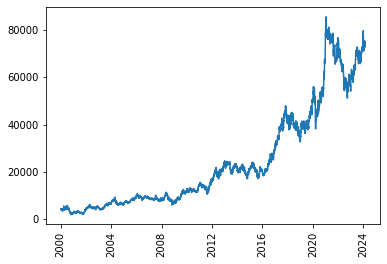

In [22]:
plt.plot(ts)

# x 축 라벨 각도 조정
plt.xticks(rotation=90)

# 그래프 표시
plt.show()

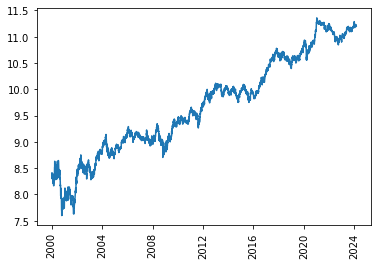

In [23]:
ts_log = np.log(ts)
plt.plot(ts_log)

# x 축 라벨 각도 조정
plt.xticks(rotation=90)

# 그래프 표시
plt.show()

In [24]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()
    
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [25]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    
    print('Results of Dickey=Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

구간 통계치(Rolling Statistics)를 시각화 & 검정을 통해 정상성 확인하기

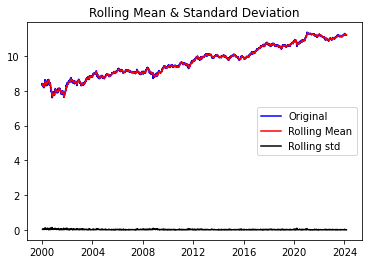

Results of Dickey=Fuller Test:
Test Statistic                   -0.591387
p-value                           0.872916
#Lags Used                        4.000000
Number of Observations Used    6050.000000
Critical Value (1%)              -3.431431
Critical Value (5%)              -2.862018
Critical Value (10%)             -2.567024
dtype: float64


In [26]:
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

계절성 추세 확인하기

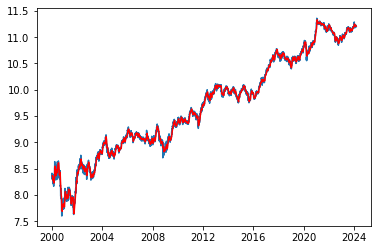

In [27]:
moving_avg = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [28]:
ts_log_moving_avg = ts_log - moving_avg
ts_log_moving_avg.head(20)

Date
2000-01-04 00:00:00+09:00         NaN
2000-01-05 00:00:00+09:00         NaN
2000-01-06 00:00:00+09:00         NaN
2000-01-07 00:00:00+09:00         NaN
2000-01-10 00:00:00+09:00         NaN
2000-01-11 00:00:00+09:00         NaN
2000-01-12 00:00:00+09:00         NaN
2000-01-13 00:00:00+09:00         NaN
2000-01-14 00:00:00+09:00         NaN
2000-01-17 00:00:00+09:00         NaN
2000-01-18 00:00:00+09:00         NaN
2000-01-19 00:00:00+09:00    0.024767
2000-01-20 00:00:00+09:00    0.039061
2000-01-21 00:00:00+09:00    0.007850
2000-01-24 00:00:00+09:00   -0.024419
2000-01-25 00:00:00+09:00   -0.069587
2000-01-26 00:00:00+09:00   -0.057965
2000-01-27 00:00:00+09:00   -0.047001
2000-01-28 00:00:00+09:00    0.004478
2000-01-31 00:00:00+09:00   -0.035715
Name: Close, dtype: float64

In [29]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(20)

Date
2000-01-19 00:00:00+09:00    0.024767
2000-01-20 00:00:00+09:00    0.039061
2000-01-21 00:00:00+09:00    0.007850
2000-01-24 00:00:00+09:00   -0.024419
2000-01-25 00:00:00+09:00   -0.069587
2000-01-26 00:00:00+09:00   -0.057965
2000-01-27 00:00:00+09:00   -0.047001
2000-01-28 00:00:00+09:00    0.004478
2000-01-31 00:00:00+09:00   -0.035715
2000-02-01 00:00:00+09:00   -0.075802
2000-02-02 00:00:00+09:00   -0.076542
2000-02-03 00:00:00+09:00   -0.085232
2000-02-04 00:00:00+09:00   -0.072735
2000-02-07 00:00:00+09:00   -0.039679
2000-02-08 00:00:00+09:00    0.002573
2000-02-09 00:00:00+09:00    0.054311
2000-02-10 00:00:00+09:00    0.056516
2000-02-11 00:00:00+09:00    0.042765
2000-02-14 00:00:00+09:00   -0.012872
2000-02-15 00:00:00+09:00   -0.037515
Name: Close, dtype: float64

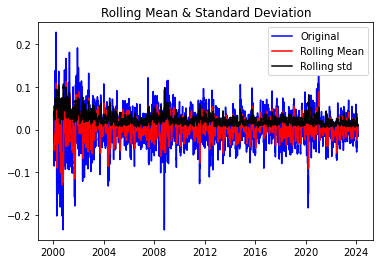

In [30]:
plot_rolling_statistics(ts_log_moving_avg)

In [31]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey=Fuller Test:
Test Statistic                -1.771016e+01
p-value                        3.505217e-30
#Lags Used                     1.100000e+01
Number of Observations Used    6.032000e+03
Critical Value (1%)           -3.431435e+00
Critical Value (5%)           -2.862019e+00
Critical Value (10%)          -2.567025e+00
dtype: float64


p-valuer가 0.05 보다 작아서 유의수준임을 확인했음

차분(Differencing) - 계절성(Seasonality) 상쇄하기

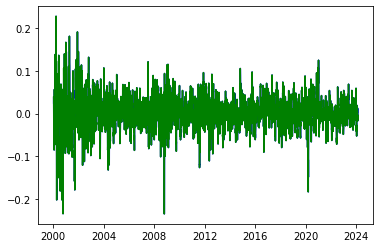

In [32]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift(-1)


plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

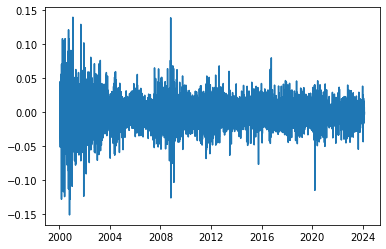

In [33]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

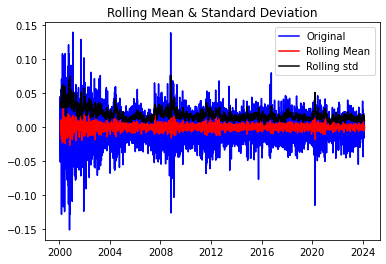

In [34]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [35]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey=Fuller Test:
Test Statistic                  -21.119148
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    6009.000000
Critical Value (1%)              -3.431439
Critical Value (5%)              -2.862021
Critical Value (10%)             -2.567026
dtype: float64


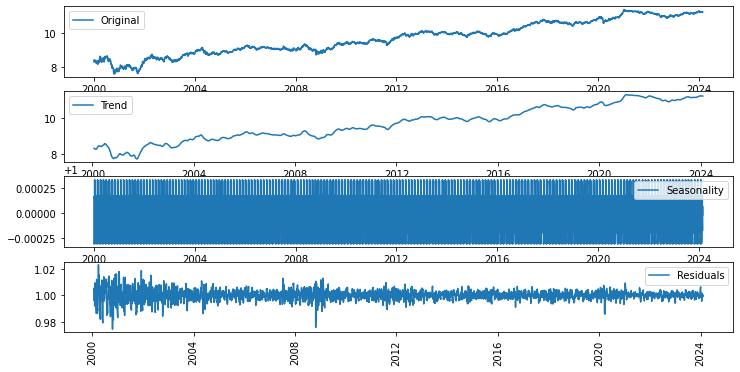

<Figure size 864x432 with 0 Axes>

In [36]:
# 시계열 분해 
from statsmodels.tsa.seasonal import seasonal_decompose
decompostition = seasonal_decompose(ts_log, model='multiplicative', period=30)

trend = decompostition.trend
seasonal = decompostition.seasonal
residual = decompostition.resid



plt.rcParams['figure.figsize'] = (12,6)

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.xticks(rotation=90)

plt.show()

plt.tight_layout()

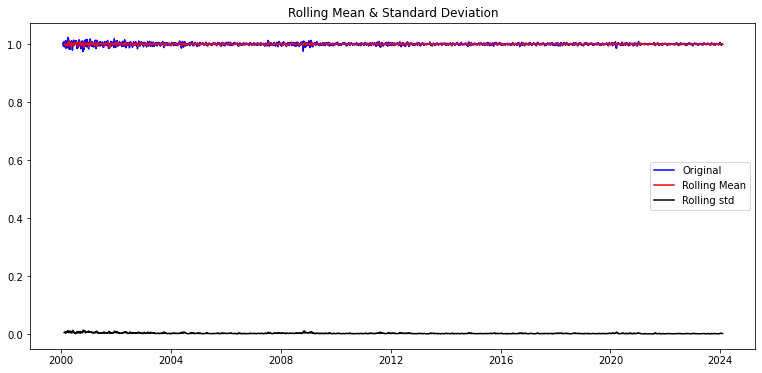

In [37]:
residual.dropna(inplace=True)
plt.rcParams['figure.figsize'] = (13,6)
plot_rolling_statistics(residual)

In [38]:
augmented_dickey_fuller_test(residual)

Results of Dickey=Fuller Test:
Test Statistic                  -18.879086
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5991.000000
Critical Value (1%)              -3.431442
Critical Value (5%)              -2.862023
Critical Value (10%)             -2.567027
dtype: float64


Results of Dickey=Fuller Test:
Test Statistic                  -42.769251
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    6050.000000
Critical Value (1%)              -3.431431
Critical Value (5%)              -2.862018
Critical Value (10%)             -2.567024
dtype: float64


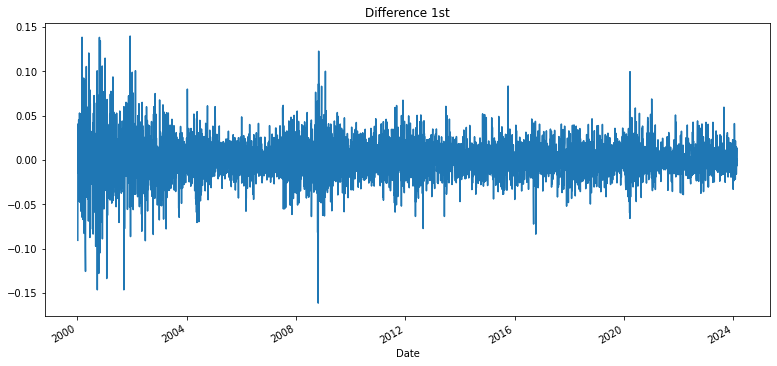

In [39]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)

Results of Dickey=Fuller Test:
Test Statistic                  -22.955018
p-value                           0.000000
#Lags Used                       34.000000
Number of Observations Used    6018.000000
Critical Value (1%)              -3.431437
Critical Value (5%)              -2.862020
Critical Value (10%)             -2.567026
dtype: float64


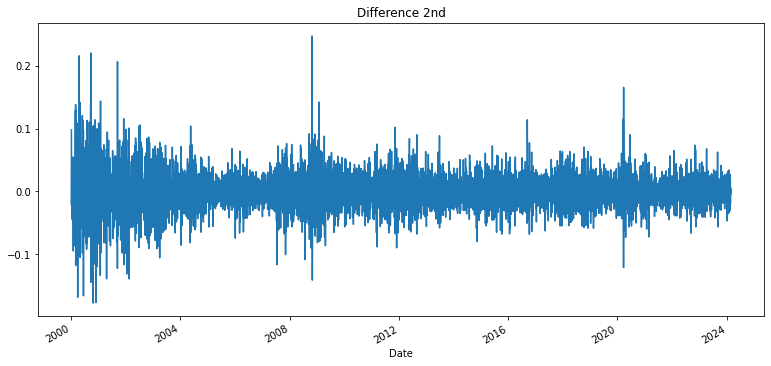

In [40]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

<AxesSubplot:title={'center':'Difference 2nd'}, xlabel='Date'>

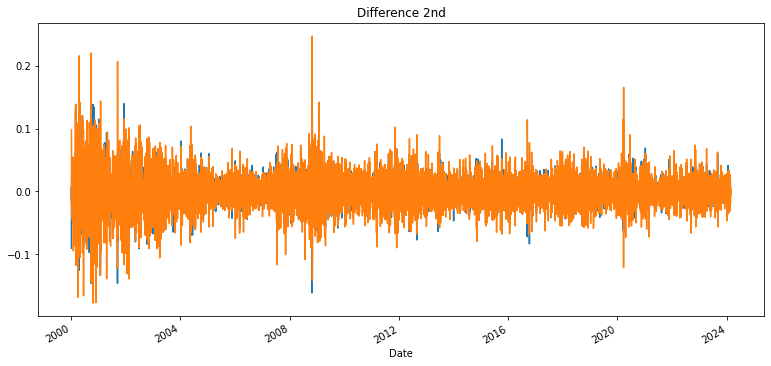

In [41]:
diff_1.plot(title='Difference 1st')
diff_2.plot(title='Difference 2nd')

차분은 1차분으로해도 충분해 보임

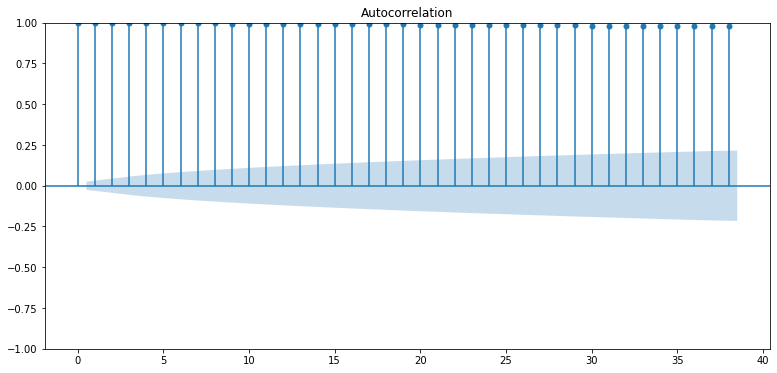

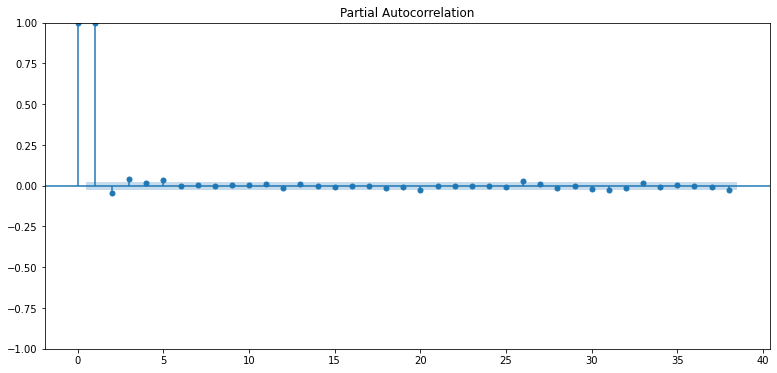

In [42]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

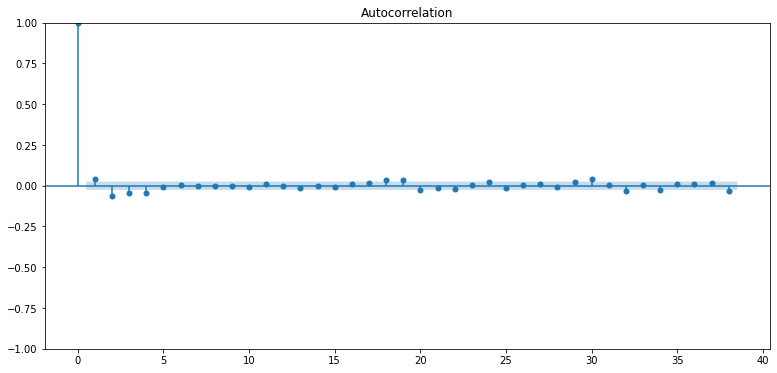

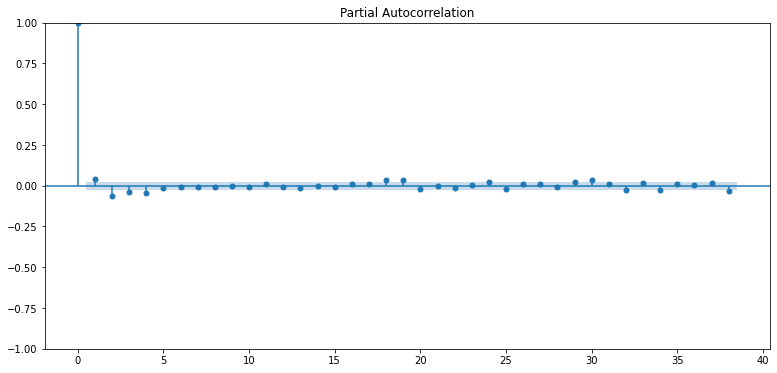

In [43]:
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

학습 데이터 분리

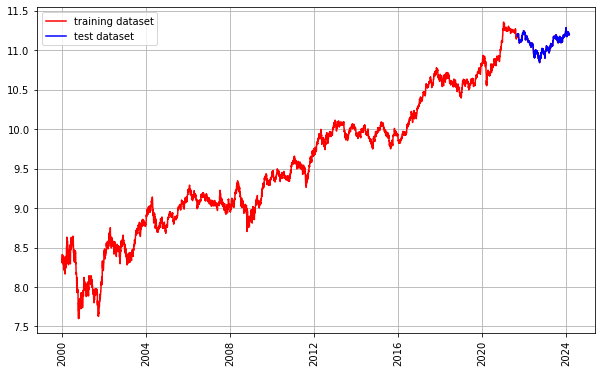

In [44]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.xticks(rotation=90)
plt.legend()

ARIMA의 모수는 3가지

- p : 자기회귀 모형(AR)의 시차
- d : 차분 누적(I) 횟수
- q : 이동평균 모형(MA)의 시차

p: 1 d:1 , q:0 으로 진행

 p 와 q 는 일반적으로 p + q < 2, p * q = 0 인 값을 사용하는데, 이는 p 나 q 중 하나는 0이라는 뜻입니다. 이렇게 하는 이유는 많은 시계열 데이터가 AR이나 MA 중 하나의 경향만 가지기 때문

In [45]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5449
Model:                 ARIMA(1, 1, 0)   Log Likelihood               12989.792
Date:                Mon, 04 Mar 2024   AIC                         -25975.584
Time:                        01:13:30   BIC                         -25962.378
Sample:                             0   HQIC                        -25970.976
                               - 5449                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0416      0.009      4.493      0.000       0.023       0.060
sigma2         0.0005   5.23e-06     95.119      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   0.02   Jarque-

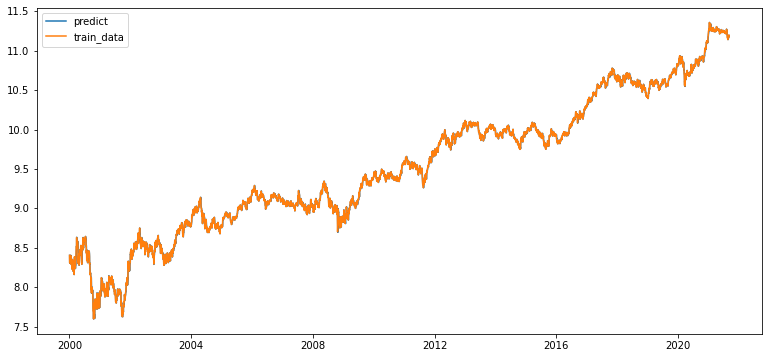

In [46]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction r

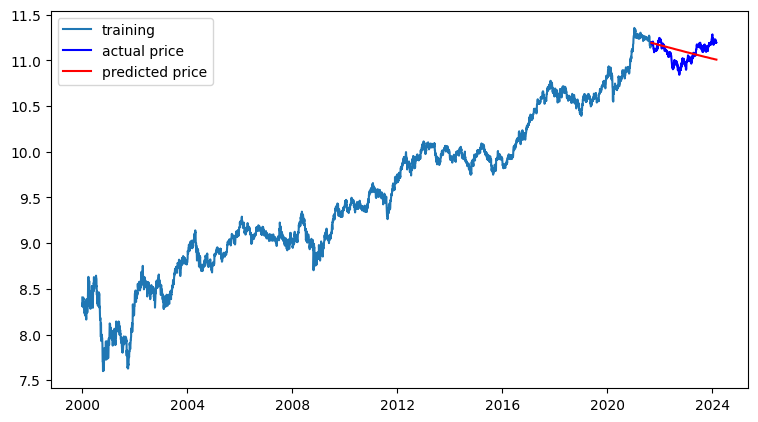

In [47]:
model = ARIMA(train_data, order=(1,0,1))
fitted_m = model.fit()
fc = fitted_m.forecast(len(test_data), alpha=0.5) # 95% conf
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(9, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

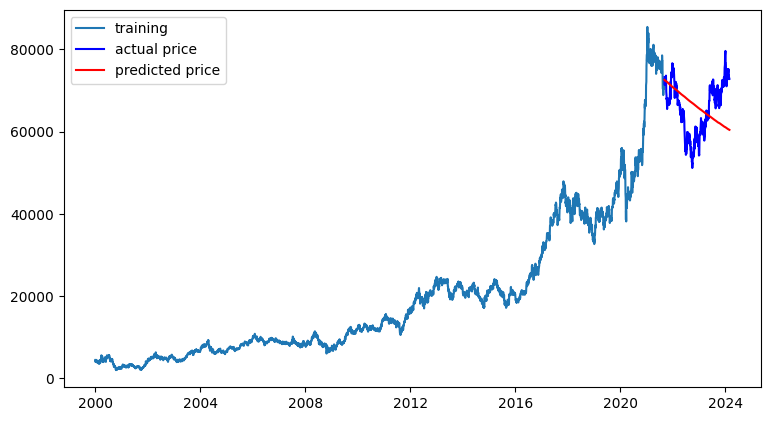

In [48]:
plt.figure(figsize=(9, 5), dpi=100)
plt.plot(np.exp(train_data), label='training')
plt.plot(np.exp(test_data), c='b', label='actual price')
plt.plot(np.exp(fc_series), c='r', label='predicted price')
plt.legend()
plt.show()

In [49]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  58580023.43867304
MAE:  6512.766380339465
RMSE:  7653.75877844821
MAPE: 10.19%


In [50]:
from statsmodels.tsa.arima.model import ARIMA
# 이동평균을 12 했을때 확인
model = ARIMA(train_data, order=(0, 1, 12))  
fitted_m = model.fit() 

print(fitted_m.summary())

/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5449
Model:                ARIMA(0, 1, 12)   Log Likelihood               13011.385
Date:                Mon, 04 Mar 2024   AIC                         -25996.769
Time:                        01:13:41   BIC                         -25910.930
Sample:                             0   HQIC                        -25966.814
                               - 5449                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0372      0.010      3.892      0.000       0.018       0.056
ma.L2         -0.0639      0.009     -6.735      0.000      -0.083      -0.045
ma.L3         -0.0384      0.010     -3.803      0.0

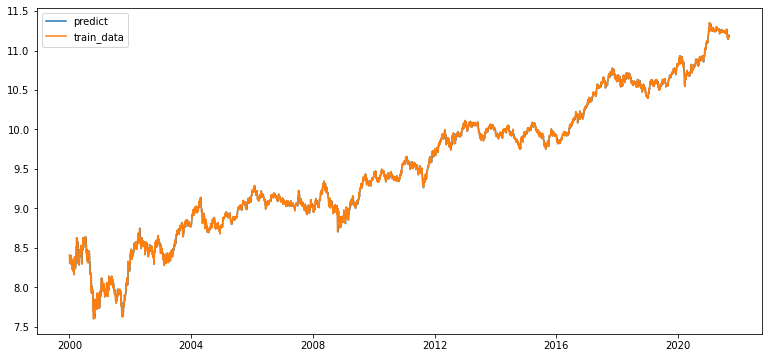

In [51]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction r

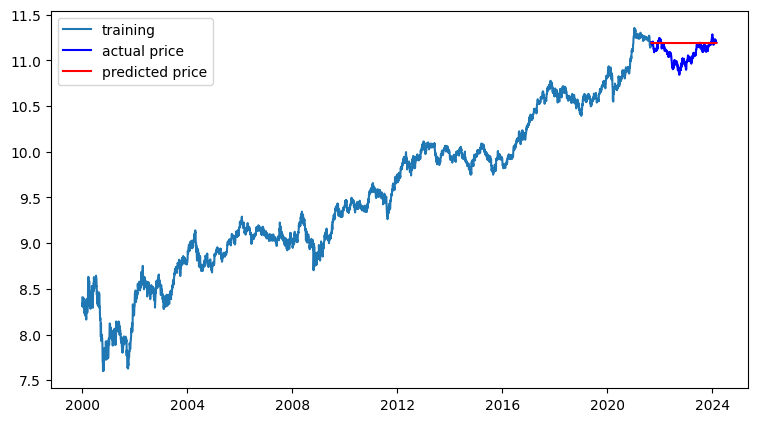

In [52]:
model = ARIMA(train_data, order=(0, 1, 12))  
fitted_m = model.fit()
fc = fitted_m.forecast(len(test_data), alpha=0.5) # 95% conf
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(9, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

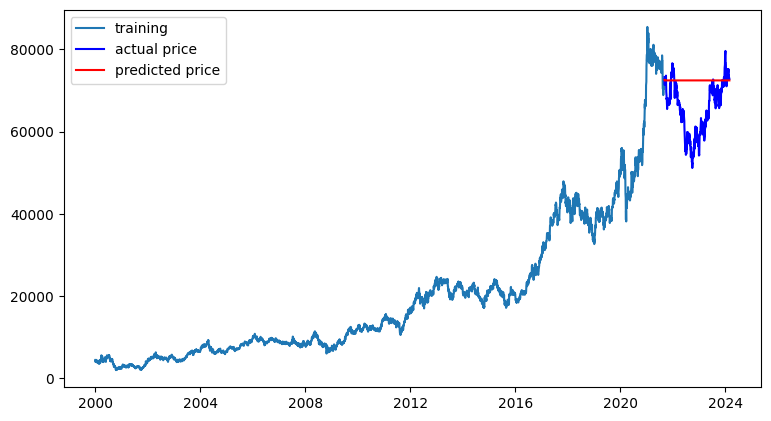

In [53]:
plt.figure(figsize=(9, 5), dpi=100)
plt.plot(np.exp(train_data), label='training')
plt.plot(np.exp(test_data), c='b', label='actual price')
plt.plot(np.exp(fc_series), c='r', label='predicted price')
plt.legend()
plt.show()

In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  86863357.82802343
MAE:  7403.84419883846
RMSE:  9320.051385481918
MAPE: 12.25%


In [55]:
from statsmodels.tsa.arima.model import ARIMA
# 이동평균을 4 했을때 확인
model = ARIMA(train_data, order=(0, 1, 4))  
fitted_m = model.fit() 

print(fitted_m.summary())

/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5449
Model:                 ARIMA(0, 1, 4)   Log Likelihood               13010.835
Date:                Mon, 04 Mar 2024   AIC                         -26011.669
Time:                        01:13:59   BIC                         -25978.654
Sample:                             0   HQIC                        -26000.148
                               - 5449                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0400      0.009      4.272      0.000       0.022       0.058
ma.L2         -0.0634      0.009     -6.739      0.000      -0.082      -0.045
ma.L3         -0.0412      0.010     -4.186      0.0

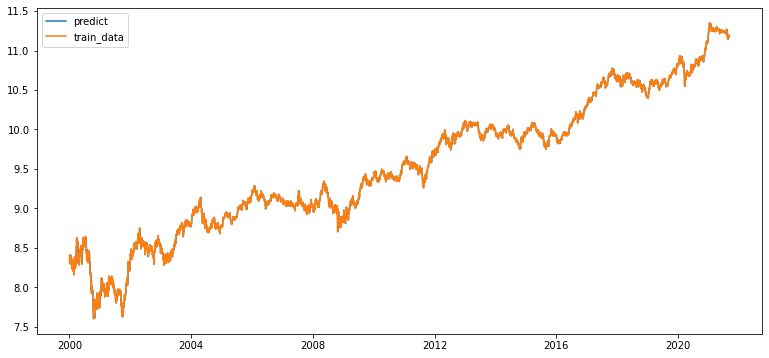

In [56]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction r

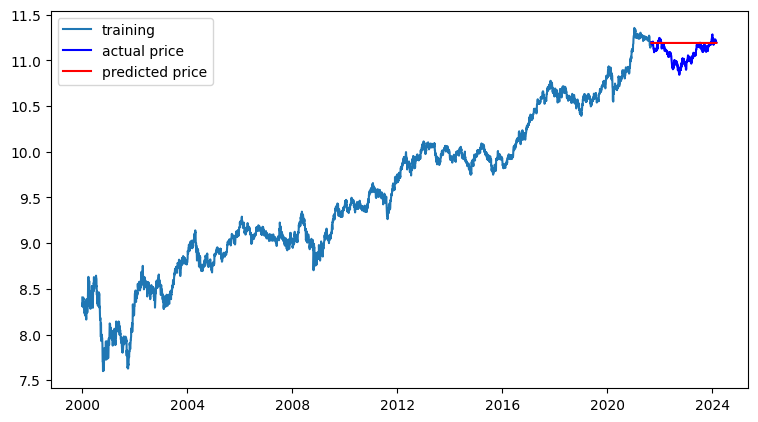

In [57]:
model = ARIMA(train_data, order=(0, 1, 4))  
fitted_m = model.fit()
fc = fitted_m.forecast(len(test_data), alpha=0.5) # 95% conf
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(9, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

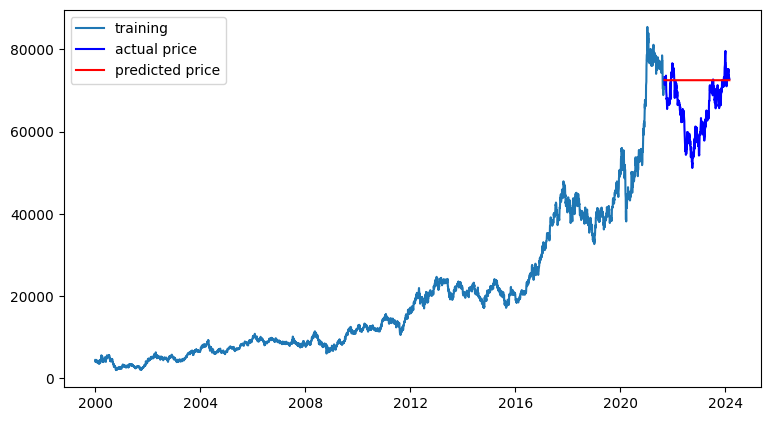

In [58]:
plt.figure(figsize=(9, 5), dpi=100)
plt.plot(np.exp(train_data), label='training')
plt.plot(np.exp(test_data), c='b', label='actual price')
plt.plot(np.exp(fc_series), c='r', label='predicted price')
plt.legend()
plt.show()

In [59]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  87538776.19951278
MAE:  7437.915213612508
RMSE:  9356.215912403517
MAPE: 12.30%


order=(1,0,1)) 가 가장 좋았다.

MSE:  58580021.85184506<br>
MAE:  6512.767548274643<br>
RMSE:  7653.758674784897<br>
MAPE: 10.19%

## 아이온큐

In [60]:
import yfinance as yf

ionq = yf.Ticker('IONQ')  # '005930.KS'는 삼성전자의 종목 코드입니다. '.KS'는 한국 시장을 의미합니다.



# 데이터 가져오기 (과거부터 오늘까지의 데이터)
ionq_data = ionq.history(period='max')


# 날짜 형식 변경 및 인덱스 설정
# ionq_data.index = pd.to_datetime(ionq_data.index).strftime('%Y-%m-%d')

# 데이터프레임 생성
df = pd.DataFrame(ionq_data,  columns=ionq_data.columns)

df


Open    High    Low  Close    Volume  Dividends  \
Date                                                                           
2021-01-04 00:00:00-05:00  11.125  11.250  10.50  10.80    150500        0.0   
2021-01-05 00:00:00-05:00  10.850  11.830  10.75  11.11    165300        0.0   
2021-01-06 00:00:00-05:00  11.500  11.500  11.00  11.05    175600        0.0   
2021-01-07 00:00:00-05:00  11.500  11.500  11.05  11.11     94200        0.0   
2021-01-08 00:00:00-05:00  11.650  12.350  11.00  11.01    137500        0.0   
...                           ...     ...    ...    ...       ...        ...   
2024-02-26 00:00:00-05:00  10.820  11.300  10.77  11.24   6379300        0.0   
2024-02-27 00:00:00-05:00  11.430  11.676  11.24  11.57   7447000        0.0   
2024-02-28 00:00:00-05:00  11.300  11.629  11.16  11.26  12725100        0.0   
2024-02-29 00:00:00-05:00  11.710  11.720  10.20  10.36  26317500        0.0   
2024-03-01 00:00:00-05:00  10.310  10.860  10.17  10.66  10174300        0.0   

                           Stock Splits  
Date                                     
2021-01-04 00:00:00-05:00           0.0  
2021-01-05 00:00:00-05:00           0.0  
2021-01-06 00:00:00-05:00           0.0  
2021-01-07 00:00:00-05:00           0.0  
2021-01-08 00:00:00-05:00           0.0  
...                                 ...  
2024-02-26 00:00:00-05:00           0.0  
2024-02-27 00:00:00-05:00           0.0  
2024-02-28 00:00:00-05:00           0.0  
2024-02-29 00:00:00-05:00           0.0  
2024-03-01 00:00:00-05:00           0.0  

[795 rows x 7 columns]

In [61]:
ts = df['Close']
ts

Date
2021-01-04 00:00:00-05:00    10.80
2021-01-05 00:00:00-05:00    11.11
2021-01-06 00:00:00-05:00    11.05
2021-01-07 00:00:00-05:00    11.11
2021-01-08 00:00:00-05:00    11.01
                             ...  
2024-02-26 00:00:00-05:00    11.24
2024-02-27 00:00:00-05:00    11.57
2024-02-28 00:00:00-05:00    11.26
2024-02-29 00:00:00-05:00    10.36
2024-03-01 00:00:00-05:00    10.66
Name: Close, Length: 795, dtype: float64

In [62]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

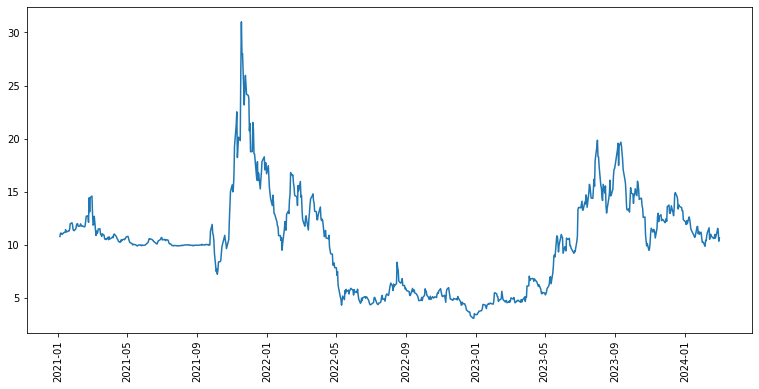

In [63]:
plt.plot(ts)

# x 축 라벨 각도 조정
plt.xticks(rotation=90)

# 그래프 표시
plt.show()

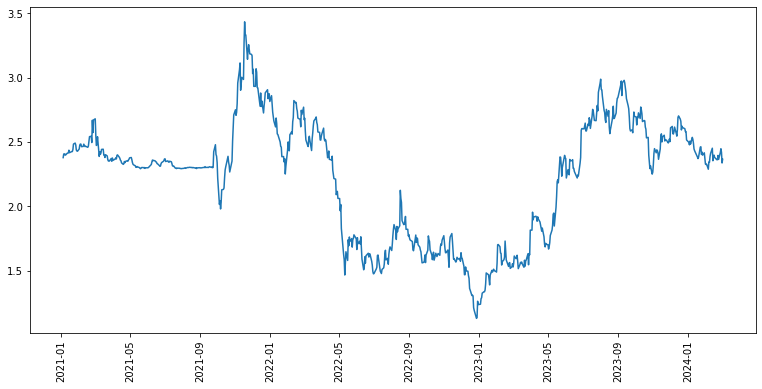

In [64]:
ts_log = np.log(ts)
plt.plot(ts_log)

# x 축 라벨 각도 조정
plt.xticks(rotation=90)

# 그래프 표시
plt.show()

구간 통계치(Rolling Statistics)를 시각화 & 검정을 통해 정상성 확인하기

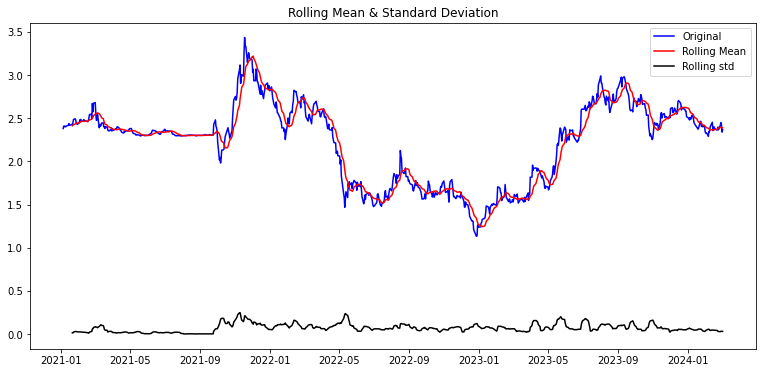

In [65]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [66]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey=Fuller Test:
Test Statistic                  -1.825774
p-value                          0.367743
#Lags Used                      16.000000
Number of Observations Used    778.000000
Critical Value (1%)             -3.438783
Critical Value (5%)             -2.865262
Critical Value (10%)            -2.568752
dtype: float64


계절성 추세 확인하기

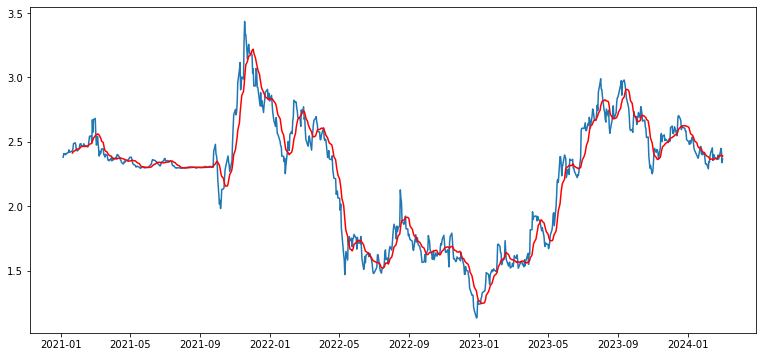

In [67]:
moving_avg = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [68]:
ts_log_moving_avg = ts_log - moving_avg
ts_log_moving_avg.head(20)

Date
2021-01-04 00:00:00-05:00         NaN
2021-01-05 00:00:00-05:00         NaN
2021-01-06 00:00:00-05:00         NaN
2021-01-07 00:00:00-05:00         NaN
2021-01-08 00:00:00-05:00         NaN
2021-01-11 00:00:00-05:00         NaN
2021-01-12 00:00:00-05:00         NaN
2021-01-13 00:00:00-05:00         NaN
2021-01-14 00:00:00-05:00         NaN
2021-01-15 00:00:00-05:00         NaN
2021-01-19 00:00:00-05:00         NaN
2021-01-20 00:00:00-05:00    0.014263
2021-01-21 00:00:00-05:00    0.024805
2021-01-22 00:00:00-05:00    0.060943
2021-01-25 00:00:00-05:00    0.060920
2021-01-26 00:00:00-05:00    0.040125
2021-01-27 00:00:00-05:00   -0.002529
2021-01-28 00:00:00-05:00   -0.011020
2021-01-29 00:00:00-05:00   -0.014038
2021-02-01 00:00:00-05:00    0.000866
Name: Close, dtype: float64

In [69]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(20)

Date
2021-01-20 00:00:00-05:00    0.014263
2021-01-21 00:00:00-05:00    0.024805
2021-01-22 00:00:00-05:00    0.060943
2021-01-25 00:00:00-05:00    0.060920
2021-01-26 00:00:00-05:00    0.040125
2021-01-27 00:00:00-05:00   -0.002529
2021-01-28 00:00:00-05:00   -0.011020
2021-01-29 00:00:00-05:00   -0.014038
2021-02-01 00:00:00-05:00    0.000866
2021-02-02 00:00:00-05:00    0.027433
2021-02-03 00:00:00-05:00    0.030201
2021-02-04 00:00:00-05:00    0.024575
2021-02-05 00:00:00-05:00    0.002029
2021-02-08 00:00:00-05:00    0.001723
2021-02-09 00:00:00-05:00    0.019462
2021-02-10 00:00:00-05:00    0.011706
2021-02-11 00:00:00-05:00    0.003389
2021-02-12 00:00:00-05:00    0.003425
2021-02-16 00:00:00-05:00   -0.007470
2021-02-17 00:00:00-05:00   -0.001422
Name: Close, dtype: float64

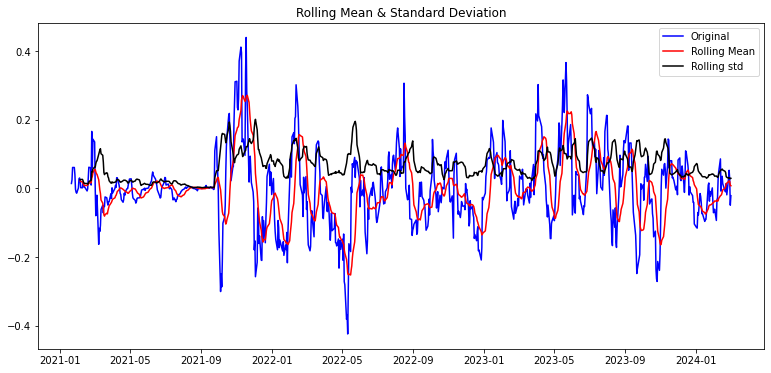

In [70]:
plot_rolling_statistics(ts_log_moving_avg)

In [71]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey=Fuller Test:
Test Statistic                -6.636527e+00
p-value                        5.544788e-09
#Lags Used                     1.500000e+01
Number of Observations Used    7.680000e+02
Critical Value (1%)           -3.438893e+00
Critical Value (5%)           -2.865311e+00
Critical Value (10%)          -2.568778e+00
dtype: float64


p-valuer가 0.05 보다 작아서 유의수준임을 확인했음

차분(Differencing) - 계절성(Seasonality) 상쇄하기

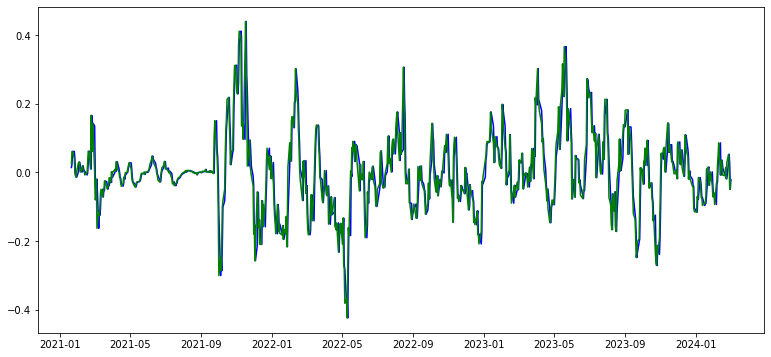

In [72]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift(-1)


plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

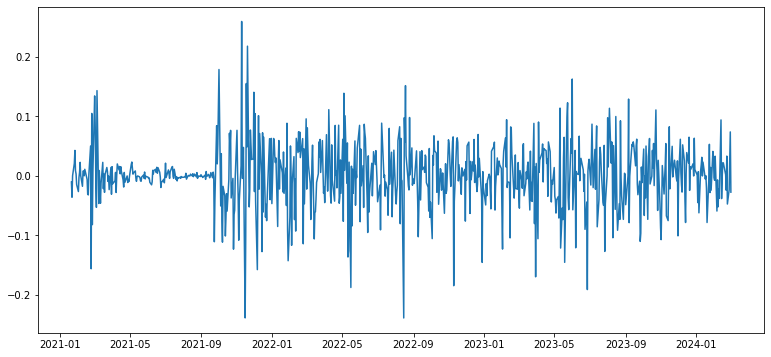

In [73]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

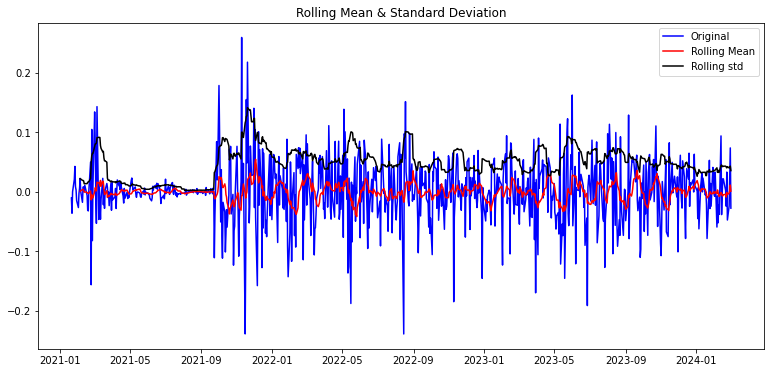

In [74]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [75]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey=Fuller Test:
Test Statistic                -1.046558e+01
p-value                        1.324405e-18
#Lags Used                     1.800000e+01
Number of Observations Used    7.640000e+02
Critical Value (1%)           -3.438938e+00
Critical Value (5%)           -2.865330e+00
Critical Value (10%)          -2.568788e+00
dtype: float64


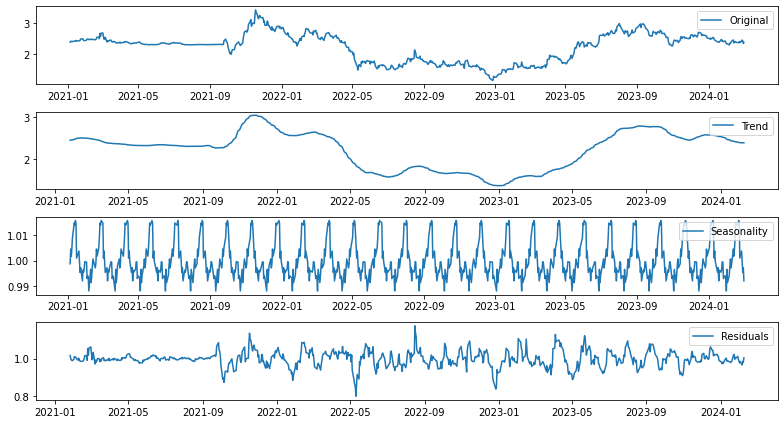

In [76]:
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 


plt.rcParams['figure.figsize'] = (11,6)


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

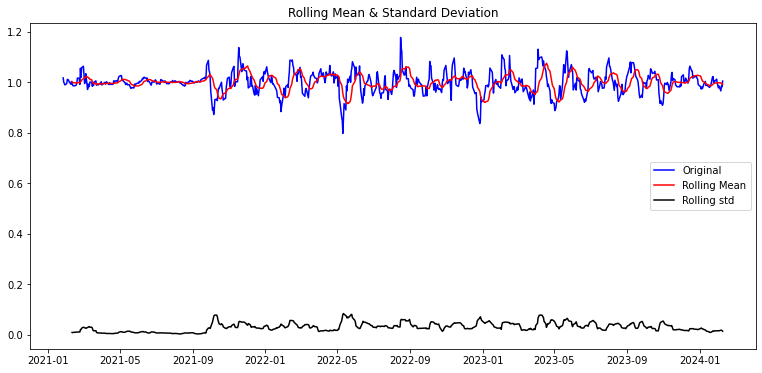

In [77]:
residual.dropna(inplace=True)
plt.rcParams['figure.figsize'] = (13,6)
plot_rolling_statistics(residual)

In [78]:
augmented_dickey_fuller_test(residual)

Results of Dickey=Fuller Test:
Test Statistic                -9.816654e+00
p-value                        5.474916e-17
#Lags Used                     1.400000e+01
Number of Observations Used    7.500000e+02
Critical Value (1%)           -3.439099e+00
Critical Value (5%)           -2.865401e+00
Critical Value (10%)          -2.568826e+00
dtype: float64


Results of Dickey=Fuller Test:
Test Statistic                -7.195309e+00
p-value                        2.443374e-10
#Lags Used                     1.500000e+01
Number of Observations Used    7.780000e+02
Critical Value (1%)           -3.438783e+00
Critical Value (5%)           -2.865262e+00
Critical Value (10%)          -2.568752e+00
dtype: float64


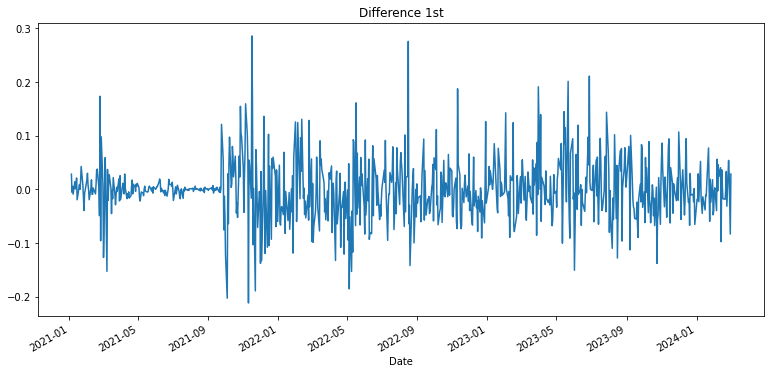

In [79]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)      

Results of Dickey=Fuller Test:
Test Statistic                -1.016878e+01
p-value                        7.181102e-18
#Lags Used                     2.000000e+01
Number of Observations Used    7.720000e+02
Critical Value (1%)           -3.438849e+00
Critical Value (5%)           -2.865291e+00
Critical Value (10%)          -2.568767e+00
dtype: float64


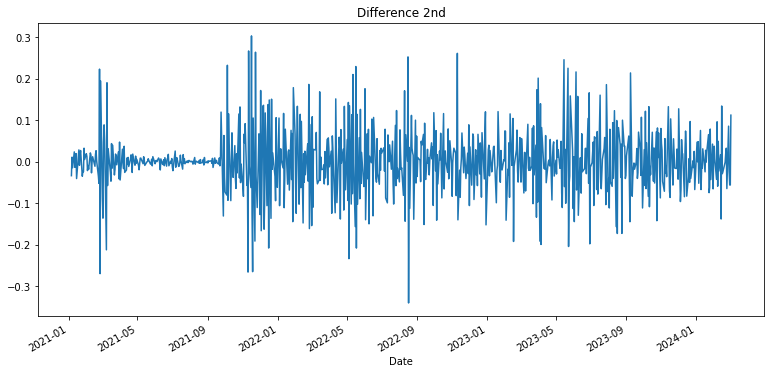

In [80]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

<AxesSubplot:title={'center':'Difference 2nd'}, xlabel='Date'>

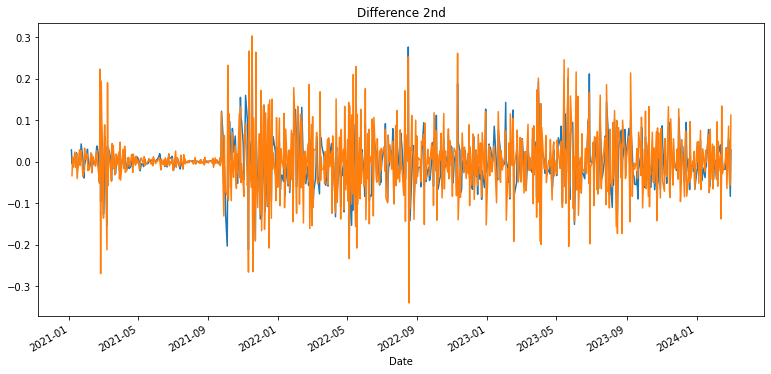

In [81]:
diff_1.plot(title='Difference 1st')
diff_2.plot(title='Difference 2nd')

1차분 충분해 보임

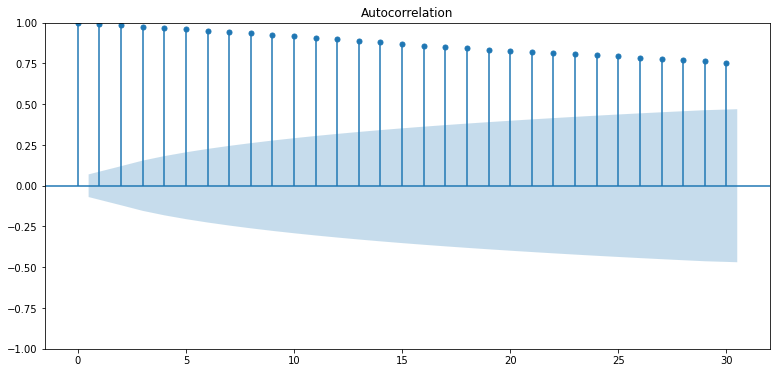

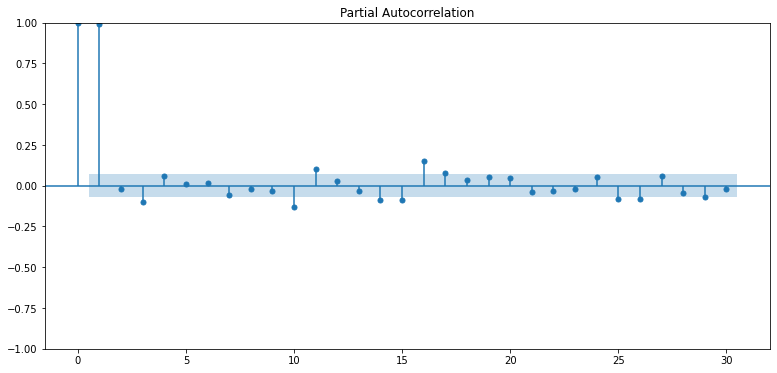

In [82]:
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

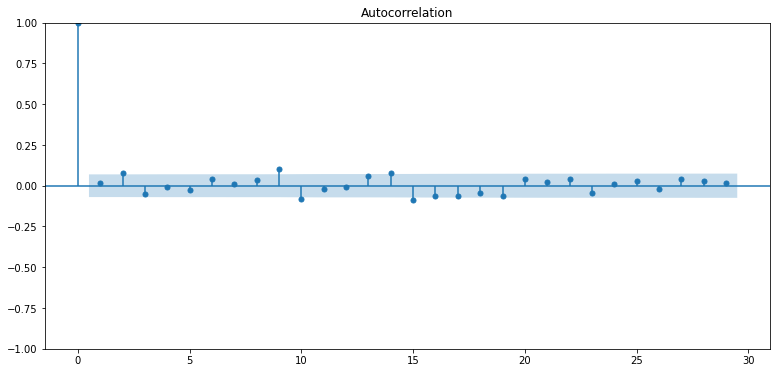

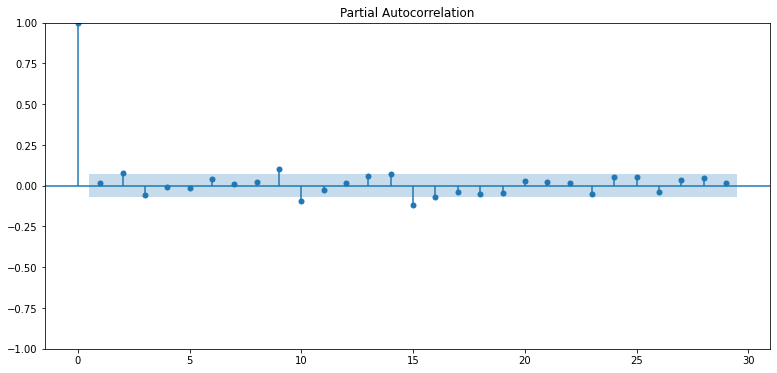

In [83]:
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

q,p값이 1~2 적합하게 보임

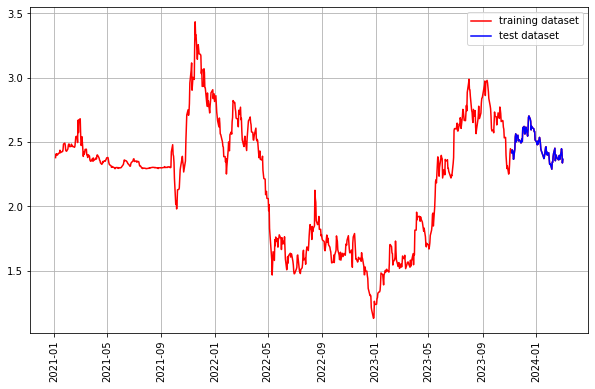

In [84]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.xticks(rotation=90)
plt.legend()

p: 2 d:1 , q:0 으로 진행

 p 와 q 는 일반적으로 p + q < 2, p * q = 0 인 값을 사용하는데, 이는 p 나 q 중 하나는 0이라는 뜻입니다. 이렇게 하는 이유는 많은 시계열 데이터가 AR이나 MA 중 하나의 경향만 가지기 때문

In [85]:
model = ARIMA(train_data, order=(2, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  715
Model:                 ARIMA(2, 1, 0)   Log Likelihood                1032.996
Date:                Mon, 04 Mar 2024   AIC                          -2059.991
Time:                        01:15:14   BIC                          -2046.279
Sample:                             0   HQIC                         -2054.695
                                - 715                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0174      0.032      0.547      0.584      -0.045       0.080
ar.L2          0.0898      0.029      3.053      0.002       0.032       0.147
sigma2         0.0032      0.000     28.741      0.0

/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


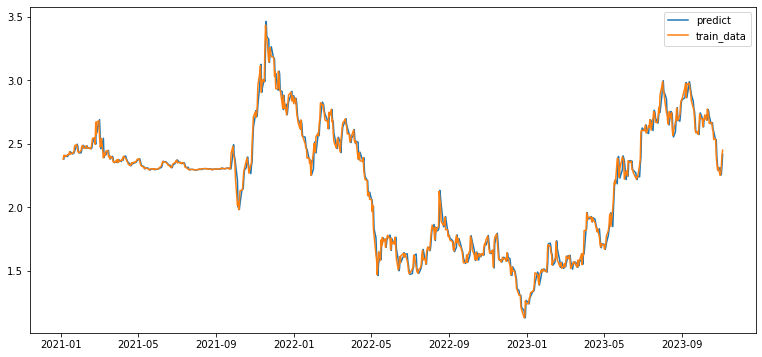

In [86]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction r

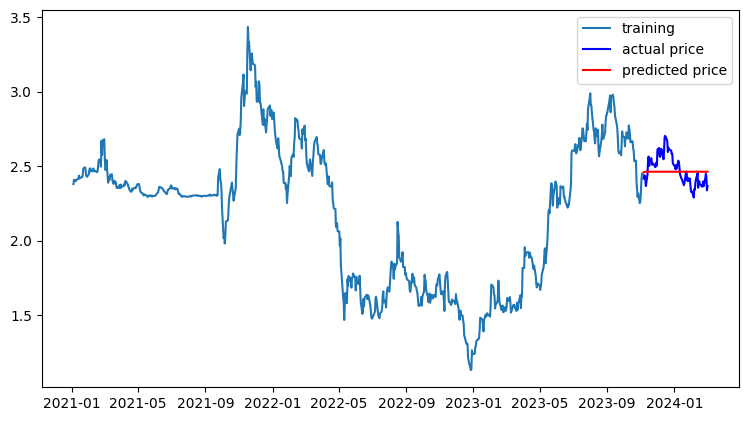

In [87]:
model = ARIMA(train_data, order=(2, 1, 0))  
fitted_m = model.fit()
fc = fitted_m.forecast(len(test_data), alpha=0.5) # 95% conf
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(9, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

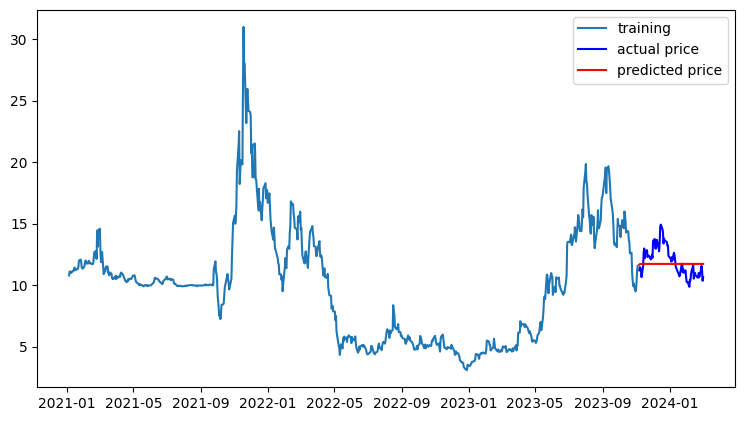

In [88]:
plt.figure(figsize=(9, 5), dpi=100)
plt.plot(np.exp(train_data), label='training')
plt.plot(np.exp(test_data), c='b', label='actual price')
plt.plot(np.exp(fc_series), c='r', label='predicted price')
plt.legend()
plt.show()

In [89]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1.4709028598339002
MAE:  1.008125747575356
RMSE:  1.2128078412650127
MAPE: 8.28%


(2, 1, 0)이 MAPE값 낮게 나옴

MSE:  1.4709028598339136
MAE:  1.0081257475753567
RMSE:  1.2128078412650183
MAPE: 8.28%

In [90]:
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  715
Model:                 ARIMA(1, 1, 0)   Log Likelihood                1030.122
Date:                Mon, 04 Mar 2024   AIC                          -2056.244
Time:                        01:15:43   BIC                          -2047.102
Sample:                             0   HQIC                         -2052.713
                                - 715                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0189      0.032      0.589      0.556      -0.044       0.082
sigma2         0.0033      0.000     29.285      0.000       0.003       0.003
Ljung-Box (L1) (Q):                   0.00   Jarque-

/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## ARM

In [92]:
import yfinance as yf


cornings = yf.Ticker('ARM')  # '005930.KS'는 삼성전자의 종목 코드입니다. '.KS'는 한국 시장을 의미합니다.



# 데이터 가져오기 (과거부터 오늘까지의 데이터)
cornings_data = cornings.history(period='max')


# 날짜 형식 변경 및 인덱스 설정
# cornings_data.index = pd.to_datetime(cornings_data.index).strftime('%Y-%m-%d')

# 데이터프레임 생성
df = pd.DataFrame(cornings_data,  columns=cornings_data.columns)

df


Open        High         Low       Close  \
Date                                                                        
2023-09-14 00:00:00-04:00   56.099998   66.279999   55.540001   63.590000   
2023-09-15 00:00:00-04:00   68.629997   69.000000   60.750000   60.750000   
2023-09-18 00:00:00-04:00   57.950001   58.741001   55.020000   58.000000   
2023-09-19 00:00:00-04:00   56.250000   56.779999   53.880001   55.169998   
2023-09-20 00:00:00-04:00   55.169998   55.400002   51.520000   52.910000   
...                               ...         ...         ...         ...   
2024-02-26 00:00:00-05:00  139.000000  149.919998  138.175003  146.199997   
2024-02-27 00:00:00-05:00  144.904999  147.330002  137.000000  137.949997   
2024-02-28 00:00:00-05:00  136.149994  136.289993  131.309998  133.860001   
2024-02-29 00:00:00-05:00  136.279999  141.220001  135.449997  141.039993   
2024-03-01 00:00:00-05:00  141.479996  144.979996  139.039993  141.619995   

                              Volume  Dividends  Stock Splits  
Date                                                           
2023-09-14 00:00:00-04:00  130534500        0.0           0.0  
2023-09-15 00:00:00-04:00   74568900        0.0           0.0  
2023-09-18 00:00:00-04:00   34571900        0.0           0.0  
2023-09-19 00:00:00-04:00   18308600        0.0           0.0  
2023-09-20 00:00:00-04:00   16369500        0.0           0.0  
...                              ...        ...           ...  
2024-02-26 00:00:00-05:00   26547900        0.0           0.0  
2024-02-27 00:00:00-05:00   17481300        0.0           0.0  
2024-02-28 00:00:00-05:00    9682600        0.0           0.0  
2024-02-29 00:00:00-05:00   10300000        0.0           0.0  
2024-03-01 00:00:00-05:00    9805300        0.0           0.0  

[117 rows x 7 columns]

In [93]:
ts = df['Close']
ts

Date
2023-09-14 00:00:00-04:00     63.590000
2023-09-15 00:00:00-04:00     60.750000
2023-09-18 00:00:00-04:00     58.000000
2023-09-19 00:00:00-04:00     55.169998
2023-09-20 00:00:00-04:00     52.910000
                                ...    
2024-02-26 00:00:00-05:00    146.199997
2024-02-27 00:00:00-05:00    137.949997
2024-02-28 00:00:00-05:00    133.860001
2024-02-29 00:00:00-05:00    141.039993
2024-03-01 00:00:00-05:00    141.619995
Name: Close, Length: 117, dtype: float64

In [94]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

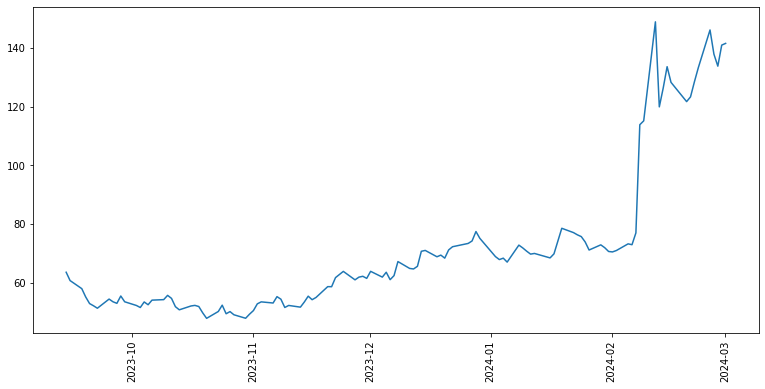

In [95]:
plt.plot(ts)

# x 축 라벨 각도 조정
plt.xticks(rotation=90)

# 그래프 표시
plt.show()

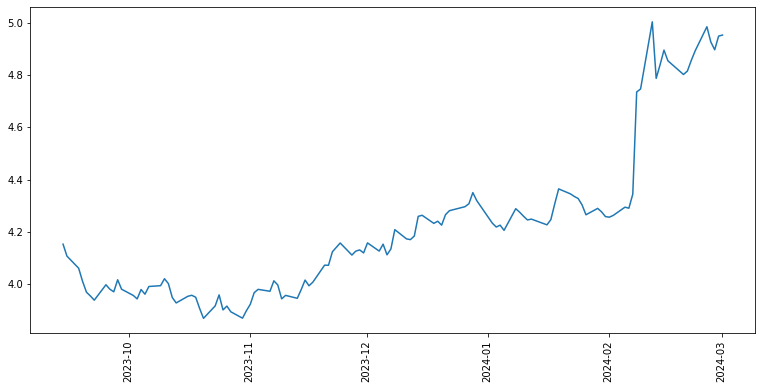

In [96]:
ts_log = np.log(ts)
plt.plot(ts_log)

# x 축 라벨 각도 조정
plt.xticks(rotation=90)

# 그래프 표시
plt.show()

구간 통계치(Rolling Statistics)를 시각화 & 검정을 통해 정상성 확인하기

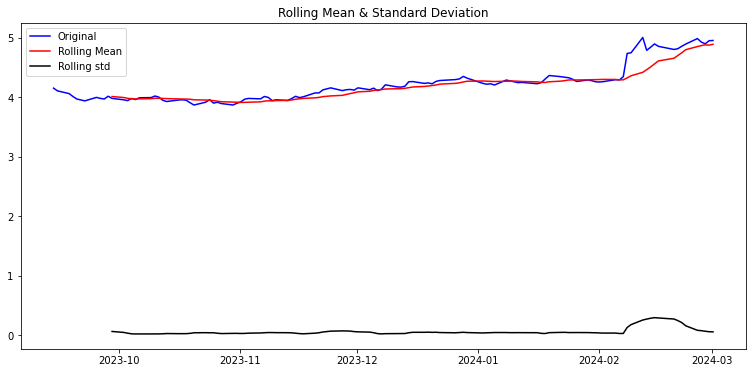

In [97]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [98]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)


Results of Dickey=Fuller Test:
Test Statistic                   0.205244
p-value                          0.972554
#Lags Used                       2.000000
Number of Observations Used    114.000000
Critical Value (1%)             -3.489058
Critical Value (5%)             -2.887246
Critical Value (10%)            -2.580481
dtype: float64


계절성 추세 확인하기

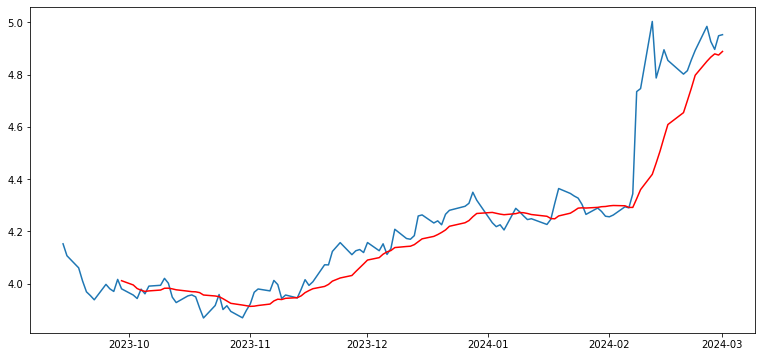

In [99]:
moving_avg = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [100]:
ts_log_moving_avg = ts_log - moving_avg
ts_log_moving_avg.head(20)

Date
2023-09-14 00:00:00-04:00         NaN
2023-09-15 00:00:00-04:00         NaN
2023-09-18 00:00:00-04:00         NaN
2023-09-19 00:00:00-04:00         NaN
2023-09-20 00:00:00-04:00         NaN
2023-09-21 00:00:00-04:00         NaN
2023-09-22 00:00:00-04:00         NaN
2023-09-25 00:00:00-04:00         NaN
2023-09-26 00:00:00-04:00         NaN
2023-09-27 00:00:00-04:00         NaN
2023-09-28 00:00:00-04:00         NaN
2023-09-29 00:00:00-04:00   -0.031160
2023-10-02 00:00:00-04:00   -0.038633
2023-10-03 00:00:00-04:00   -0.038271
2023-10-04 00:00:00-04:00    0.004515
2023-10-05 00:00:00-04:00   -0.009298
2023-10-06 00:00:00-04:00    0.018341
2023-10-09 00:00:00-04:00    0.018205
2023-10-10 00:00:00-04:00    0.037922
2023-10-11 00:00:00-04:00    0.018894
Name: Close, dtype: float64

In [101]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(20)

Date
2023-09-29 00:00:00-04:00   -0.031160
2023-10-02 00:00:00-04:00   -0.038633
2023-10-03 00:00:00-04:00   -0.038271
2023-10-04 00:00:00-04:00    0.004515
2023-10-05 00:00:00-04:00   -0.009298
2023-10-06 00:00:00-04:00    0.018341
2023-10-09 00:00:00-04:00    0.018205
2023-10-10 00:00:00-04:00    0.037922
2023-10-11 00:00:00-04:00    0.018894
2023-10-12 00:00:00-04:00   -0.031608
2023-10-13 00:00:00-04:00   -0.048910
2023-10-16 00:00:00-04:00   -0.018170
2023-10-17 00:00:00-04:00   -0.012401
2023-10-18 00:00:00-04:00   -0.019311
2023-10-19 00:00:00-04:00   -0.058809
2023-10-20 00:00:00-04:00   -0.087926
2023-10-23 00:00:00-04:00   -0.036468
2023-10-24 00:00:00-04:00    0.008329
2023-10-25 00:00:00-04:00   -0.041508
2023-10-26 00:00:00-04:00   -0.018122
Name: Close, dtype: float64

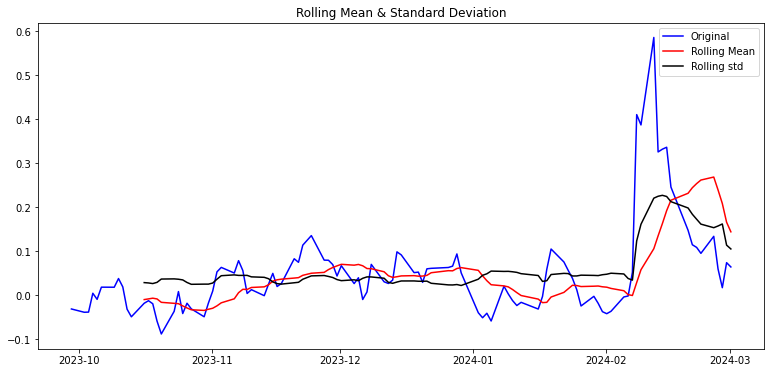

In [102]:
plot_rolling_statistics(ts_log_moving_avg)

In [103]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey=Fuller Test:
Test Statistic                  -3.483708
p-value                          0.008415
#Lags Used                       2.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64


차분(Differencing) - 계절성(Seasonality) 상쇄하기

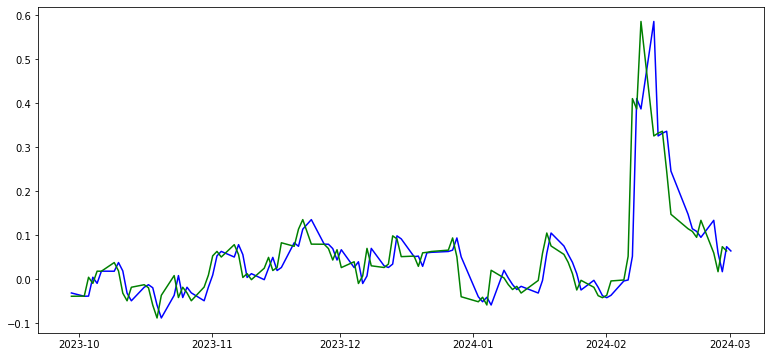

In [104]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift(-1)


plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

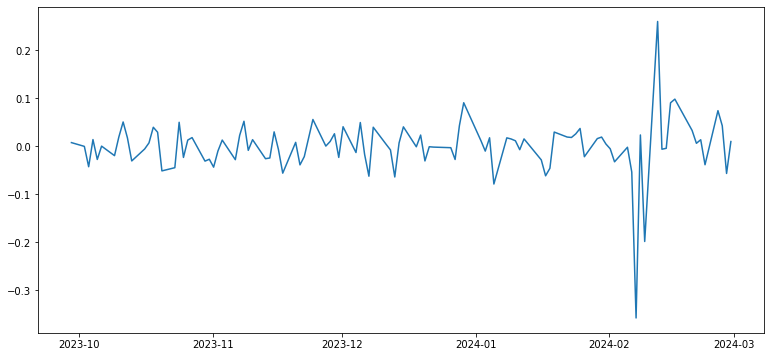

In [105]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

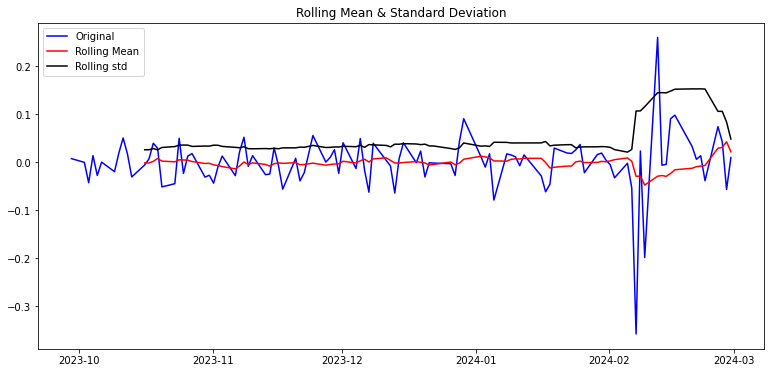

In [106]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [107]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey=Fuller Test:
Test Statistic                -6.282804e+00
p-value                        3.760431e-08
#Lags Used                     1.000000e+00
Number of Observations Used    1.030000e+02
Critical Value (1%)           -3.495493e+00
Critical Value (5%)           -2.890037e+00
Critical Value (10%)          -2.581971e+00
dtype: float64


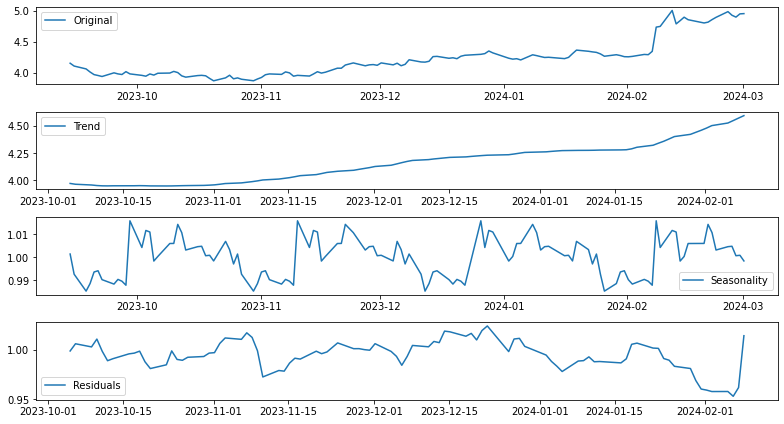

In [108]:
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)
#시계열 데이터에 0 또는 음수 값이 있어서 발생한 오류이며, 이러한 값은 계절성을 곱하는 방법으로 분해할 수 없음


plt.rcParams['figure.figsize'] = (11,6)


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

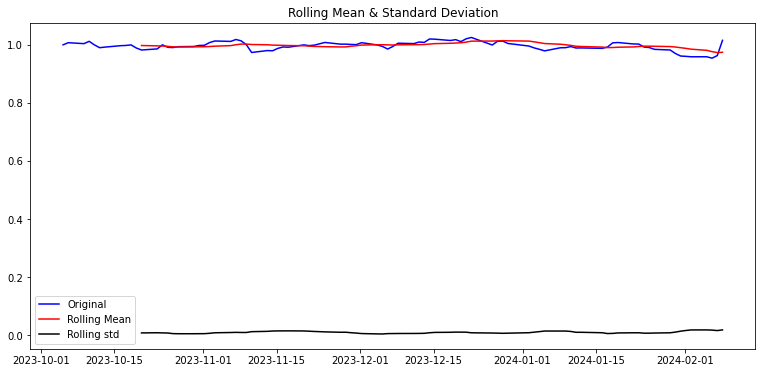

In [109]:
residual.dropna(inplace=True)
plt.rcParams['figure.figsize'] = (13,6)
plot_rolling_statistics(residual)


In [110]:
augmented_dickey_fuller_test(residual)

Results of Dickey=Fuller Test:
Test Statistic                 -3.360215
p-value                         0.012392
#Lags Used                      1.000000
Number of Observations Used    85.000000
Critical Value (1%)            -3.509736
Critical Value (5%)            -2.896195
Critical Value (10%)           -2.585258
dtype: float64


Results of Dickey=Fuller Test:
Test Statistic                -6.659684e+00
p-value                        4.882725e-09
#Lags Used                     1.000000e+00
Number of Observations Used    1.140000e+02
Critical Value (1%)           -3.489058e+00
Critical Value (5%)           -2.887246e+00
Critical Value (10%)          -2.580481e+00
dtype: float64


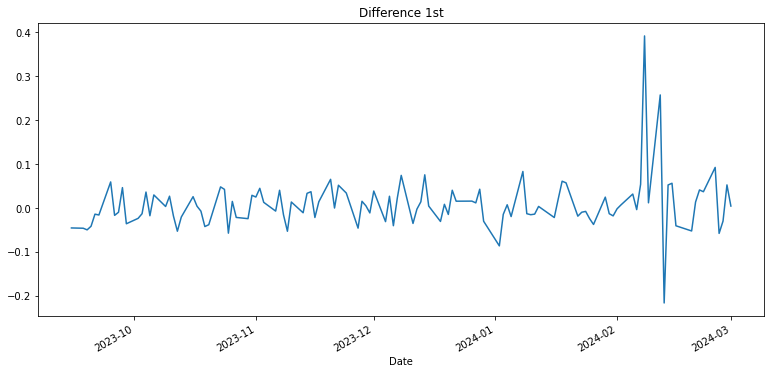

In [111]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)

Results of Dickey=Fuller Test:
Test Statistic                -6.842400e+00
p-value                        1.777488e-09
#Lags Used                     7.000000e+00
Number of Observations Used    1.070000e+02
Critical Value (1%)           -3.492996e+00
Critical Value (5%)           -2.888955e+00
Critical Value (10%)          -2.581393e+00
dtype: float64


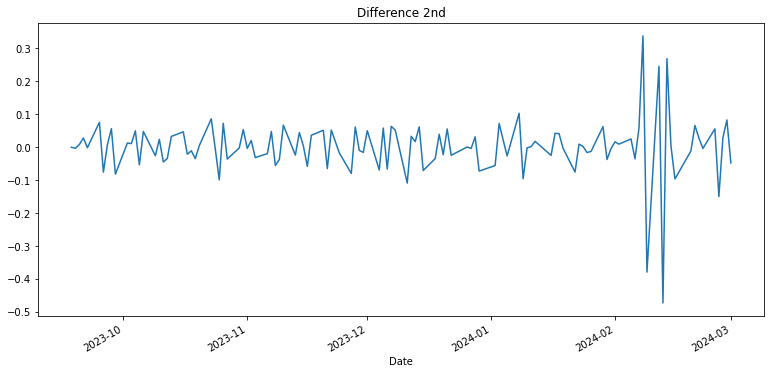

In [112]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')
augmented_dickey_fuller_test(diff_2)

<AxesSubplot:title={'center':'Difference 2nd'}, xlabel='Date'>

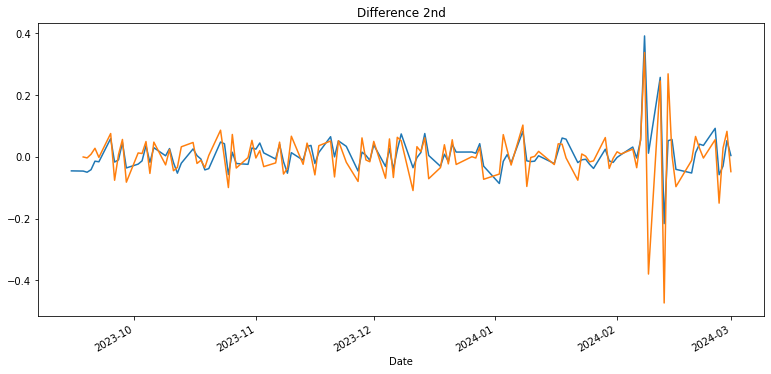

In [113]:
diff_1.plot(title='Difference 1st')
diff_2.plot(title='Difference 2nd')

차분은 1차분으로해도 충분해 보임

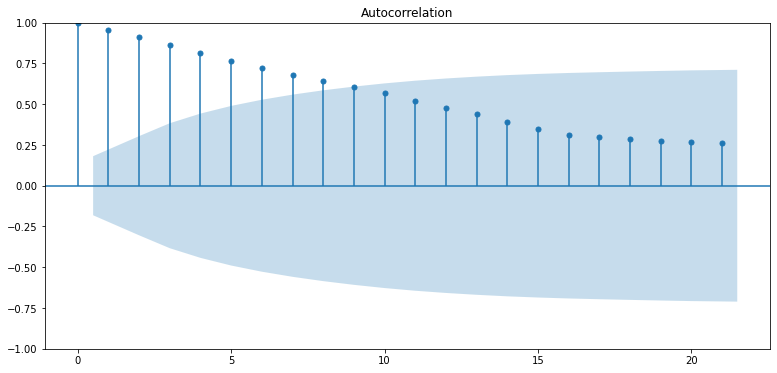

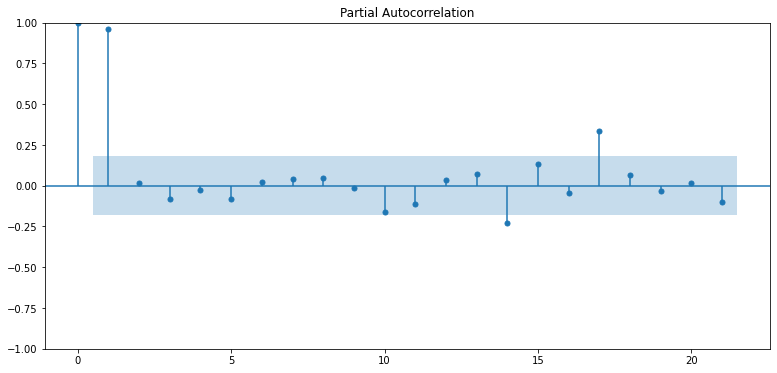

In [114]:
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

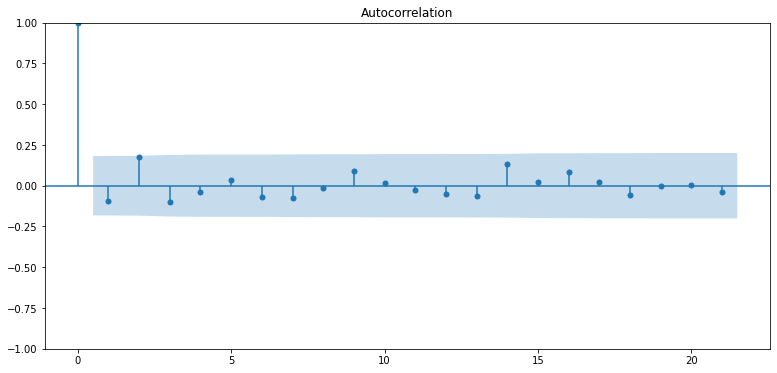

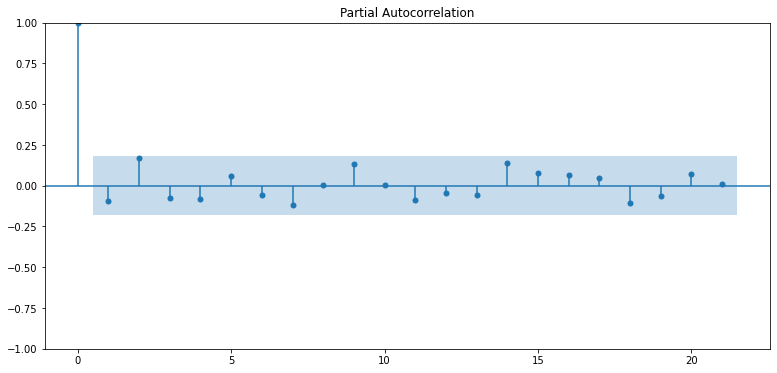

In [115]:
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

학습 데이터 분리

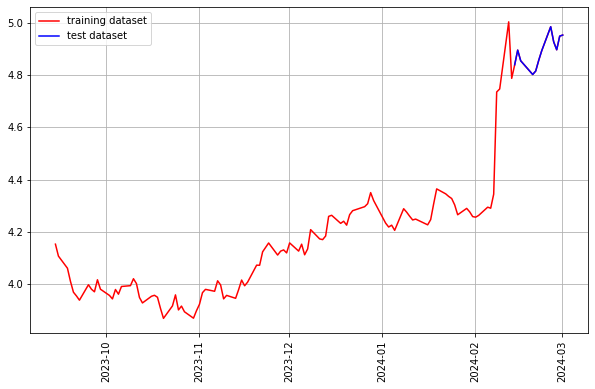

In [116]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.xticks(rotation=90)
plt.legend()

In [117]:
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  105
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 144.485
Date:                Mon, 04 Mar 2024   AIC                           -284.969
Time:                        01:16:47   BIC                           -279.681
Sample:                             0   HQIC                          -282.827
                                - 105                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0698      0.063     -1.104      0.270      -0.194       0.054
sigma2         0.0036      0.000     23.233      0.000       0.003       0.004
Ljung-Box (L1) (Q):                   0.00   Jarque-

/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


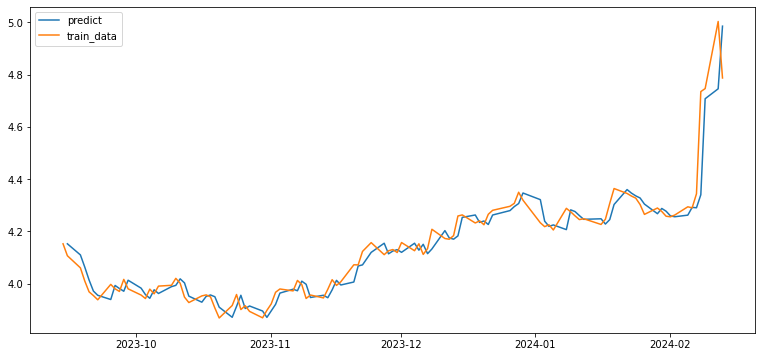

In [118]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction r

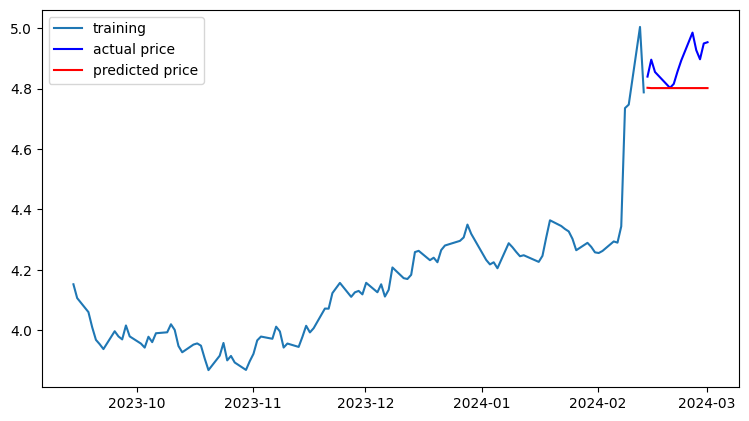

In [119]:
model = ARIMA(train_data, order=(1, 1, 0)) 
fitted_m = model.fit()
fc = fitted_m.forecast(len(test_data), alpha=0.5) # 95% conf
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(9, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

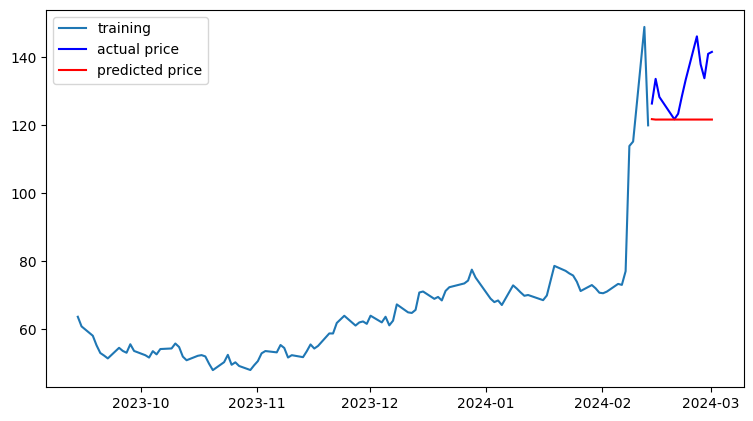

In [120]:
plt.figure(figsize=(9, 5), dpi=100)
plt.plot(np.exp(train_data), label='training')
plt.plot(np.exp(test_data), c='b', label='actual price')
plt.plot(np.exp(fc_series), c='r', label='predicted price')
plt.legend()
plt.show()

In [121]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  181.72298026861418
MAE:  11.314942092002056
RMSE:  13.480466619097953
MAPE: 8.23%


## 쿠팡

In [124]:
import yfinance as yf

cisco = yf.Ticker('CPNG')  



# 데이터 가져오기 (과거부터 오늘까지의 데이터)
cisco_data = cisco.history(period='max')


# 날짜 형식 변경 및 인덱스 설정
# cisco_data.index = pd.to_datetime(cisco_data.index).strftime('%Y-%m-%d')

# 데이터프레임 생성
df = pd.DataFrame(cisco_data,  columns=cisco_data.columns)

df


Open       High        Low      Close  \
Date                                                                    
2021-03-11 00:00:00-05:00  63.500000  69.000000  49.250000  49.250000   
2021-03-12 00:00:00-05:00  52.540001  52.759998  46.250000  48.470001   
2021-03-15 00:00:00-04:00  50.130001  51.849998  49.020000  50.450001   
2021-03-16 00:00:00-04:00  50.590000  50.770000  46.700001  47.130001   
2021-03-17 00:00:00-04:00  46.000000  46.900002  43.189999  43.290001   
...                              ...        ...        ...        ...   
2024-02-26 00:00:00-05:00  16.309999  16.400000  15.805000  16.389999   
2024-02-27 00:00:00-05:00  16.480000  17.250000  16.455000  16.889999   
2024-02-28 00:00:00-05:00  18.020000  18.299999  17.320000  18.240000   
2024-02-29 00:00:00-05:00  18.350000  18.950001  18.250000  18.520000   
2024-03-01 00:00:00-05:00  18.459999  19.055000  18.315001  18.950001   

                             Volume  Dividends  Stock Splits  
Date                                                          
2021-03-11 00:00:00-05:00  91584100        0.0           0.0  
2021-03-12 00:00:00-05:00  30521000        0.0           0.0  
2021-03-15 00:00:00-04:00  17387800        0.0           0.0  
2021-03-16 00:00:00-04:00  14552400        0.0           0.0  
2021-03-17 00:00:00-04:00  15251100        0.0           0.0  
...                             ...        ...           ...  
2024-02-26 00:00:00-05:00  11758700        0.0           0.0  
2024-02-27 00:00:00-05:00  21103300        0.0           0.0  
2024-02-28 00:00:00-05:00  33870400        0.0           0.0  
2024-02-29 00:00:00-05:00  20617500        0.0           0.0  
2024-03-01 00:00:00-05:00  19577400        0.0           0.0  

[749 rows x 7 columns]

In [125]:
ts = df['Close']
ts

Date
2021-03-11 00:00:00-05:00    49.250000
2021-03-12 00:00:00-05:00    48.470001
2021-03-15 00:00:00-04:00    50.450001
2021-03-16 00:00:00-04:00    47.130001
2021-03-17 00:00:00-04:00    43.290001
                               ...    
2024-02-26 00:00:00-05:00    16.389999
2024-02-27 00:00:00-05:00    16.889999
2024-02-28 00:00:00-05:00    18.240000
2024-02-29 00:00:00-05:00    18.520000
2024-03-01 00:00:00-05:00    18.950001
Name: Close, Length: 749, dtype: float64

In [126]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

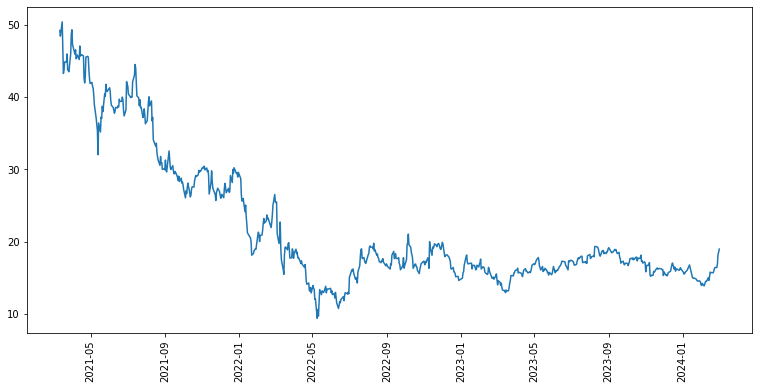

In [127]:
plt.plot(ts)

# x 축 라벨 각도 조정
plt.xticks(rotation=90)

# 그래프 표시
plt.show()

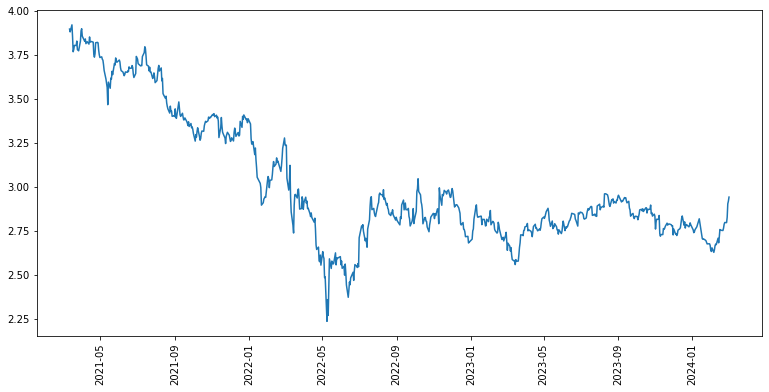

In [128]:
ts_log = np.log(ts)
plt.plot(ts_log)

# x 축 라벨 각도 조정
plt.xticks(rotation=90)

# 그래프 표시
plt.show()

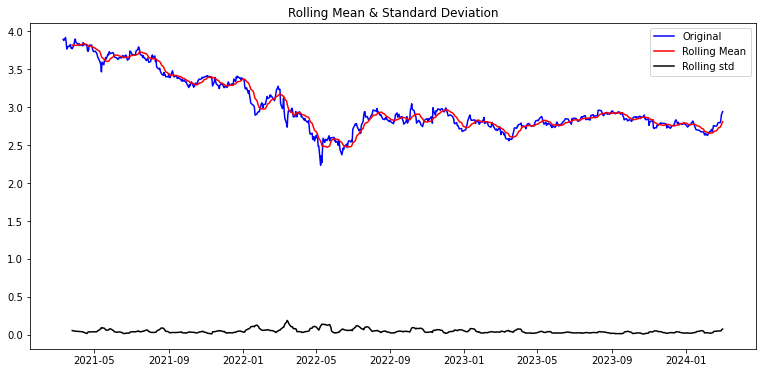

In [129]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [130]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey=Fuller Test:
Test Statistic                  -2.398685
p-value                          0.142108
#Lags Used                       1.000000
Number of Observations Used    747.000000
Critical Value (1%)             -3.439134
Critical Value (5%)             -2.865417
Critical Value (10%)            -2.568834
dtype: float64


계절성 추세 확인하기

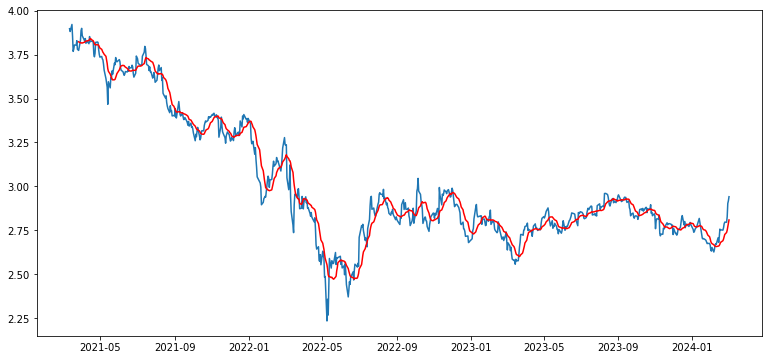

In [131]:
moving_avg = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [132]:
ts_log_moving_avg = ts_log - moving_avg
ts_log_moving_avg.head(20)

Date
2021-03-11 00:00:00-05:00         NaN
2021-03-12 00:00:00-05:00         NaN
2021-03-15 00:00:00-04:00         NaN
2021-03-16 00:00:00-04:00         NaN
2021-03-17 00:00:00-04:00         NaN
2021-03-18 00:00:00-04:00         NaN
2021-03-19 00:00:00-04:00         NaN
2021-03-22 00:00:00-04:00         NaN
2021-03-23 00:00:00-04:00         NaN
2021-03-24 00:00:00-04:00         NaN
2021-03-25 00:00:00-04:00         NaN
2021-03-26 00:00:00-04:00   -0.048880
2021-03-29 00:00:00-04:00    0.012199
2021-03-30 00:00:00-04:00    0.069566
2021-03-31 00:00:00-04:00    0.083636
2021-04-01 00:00:00-04:00    0.041102
2021-04-05 00:00:00-04:00    0.006765
2021-04-06 00:00:00-04:00    0.015446
2021-04-07 00:00:00-04:00   -0.012354
2021-04-08 00:00:00-04:00   -0.008181
Name: Close, dtype: float64

In [133]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(20)

Date
2021-03-26 00:00:00-04:00   -0.048880
2021-03-29 00:00:00-04:00    0.012199
2021-03-30 00:00:00-04:00    0.069566
2021-03-31 00:00:00-04:00    0.083636
2021-04-01 00:00:00-04:00    0.041102
2021-04-05 00:00:00-04:00    0.006765
2021-04-06 00:00:00-04:00    0.015446
2021-04-07 00:00:00-04:00   -0.012354
2021-04-08 00:00:00-04:00   -0.008181
2021-04-09 00:00:00-04:00   -0.002003
2021-04-12 00:00:00-04:00   -0.018516
2021-04-13 00:00:00-04:00    0.015974
2021-04-14 00:00:00-04:00   -0.018055
2021-04-15 00:00:00-04:00   -0.015706
2021-04-16 00:00:00-04:00   -0.008505
2021-04-19 00:00:00-04:00   -0.006068
2021-04-20 00:00:00-04:00   -0.067580
2021-04-21 00:00:00-04:00   -0.075198
2021-04-22 00:00:00-04:00   -0.048605
2021-04-23 00:00:00-04:00    0.013232
Name: Close, dtype: float64

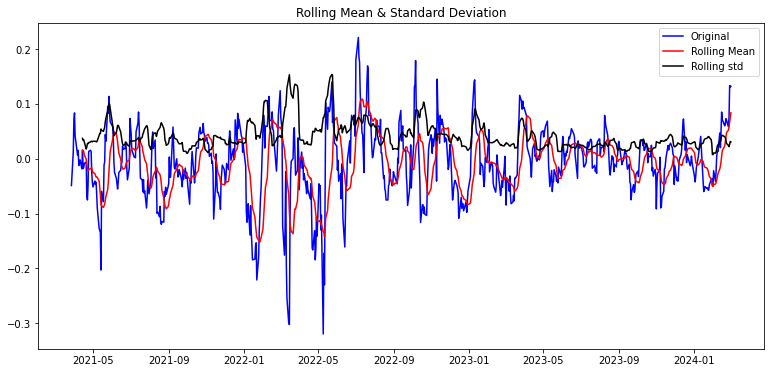

In [134]:
plot_rolling_statistics(ts_log_moving_avg)

In [135]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey=Fuller Test:
Test Statistic                -7.673280e+00
p-value                        1.572874e-11
#Lags Used                     9.000000e+00
Number of Observations Used    7.280000e+02
Critical Value (1%)           -3.439364e+00
Critical Value (5%)           -2.865518e+00
Critical Value (10%)          -2.568888e+00
dtype: float64


차분(Differencing) - 계절성(Seasonality) 상쇄하기

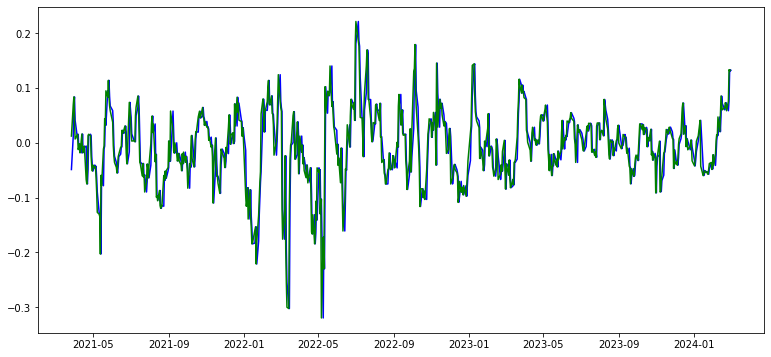

In [136]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift(-1)


plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

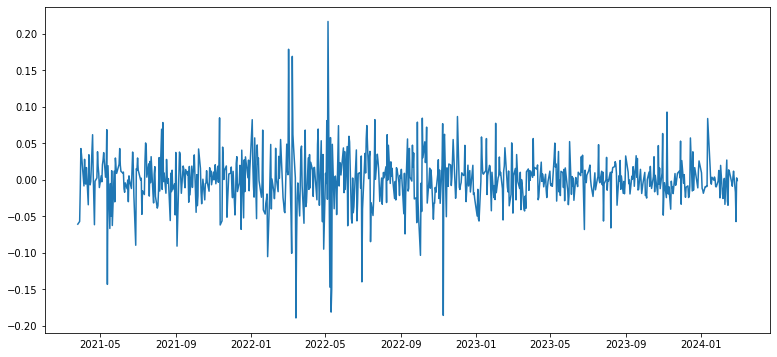

In [137]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

In [138]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey=Fuller Test:
Test Statistic                -8.776841e+00
p-value                        2.435887e-14
#Lags Used                     1.800000e+01
Number of Observations Used    7.180000e+02
Critical Value (1%)           -3.439490e+00
Critical Value (5%)           -2.865574e+00
Critical Value (10%)          -2.568918e+00
dtype: float64


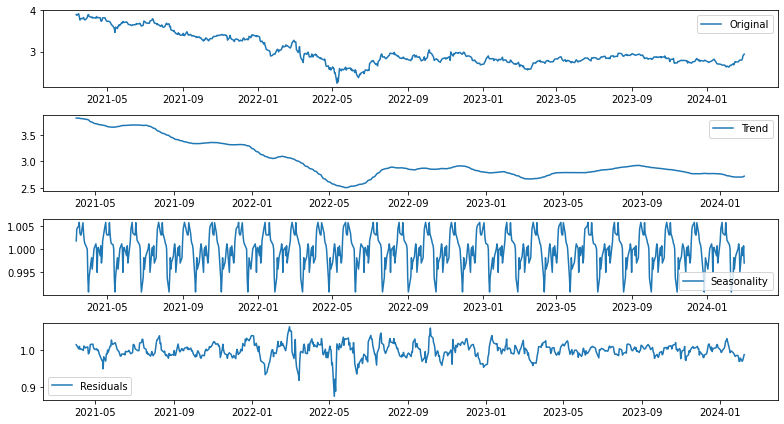

In [139]:
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 


plt.rcParams['figure.figsize'] = (11,6)


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

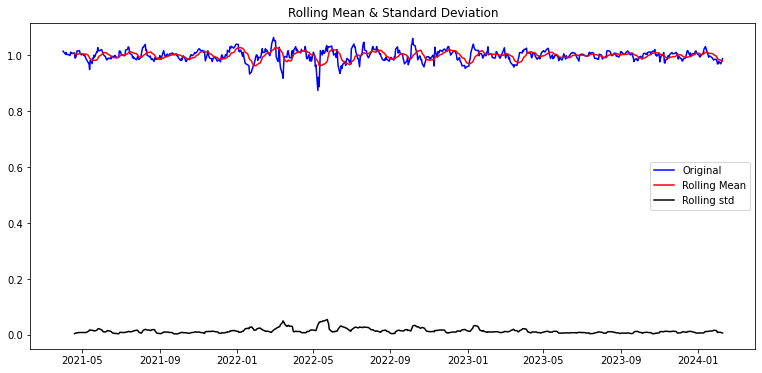

In [140]:
residual.dropna(inplace=True)
plt.rcParams['figure.figsize'] = (13,6)
plot_rolling_statistics(residual)

In [141]:
augmented_dickey_fuller_test(residual)

Results of Dickey=Fuller Test:
Test Statistic                -8.942152e+00
p-value                        9.191534e-15
#Lags Used                     1.800000e+01
Number of Observations Used    7.000000e+02
Critical Value (1%)           -3.439726e+00
Critical Value (5%)           -2.865678e+00
Critical Value (10%)          -2.568973e+00
dtype: float64


Results of Dickey=Fuller Test:
Test Statistic                 -28.767198
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    747.000000
Critical Value (1%)             -3.439134
Critical Value (5%)             -2.865417
Critical Value (10%)            -2.568834
dtype: float64


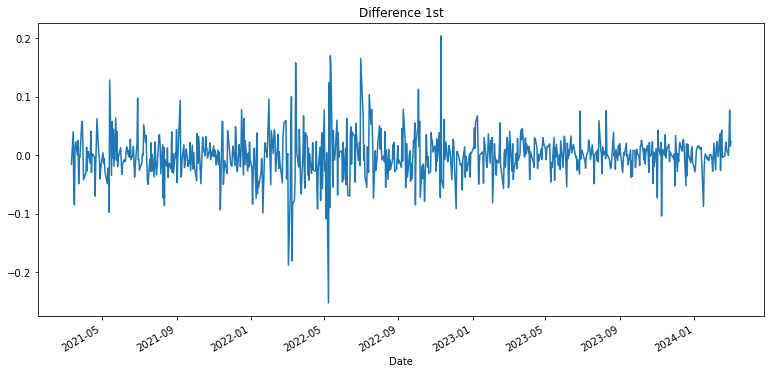

In [142]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)

Results of Dickey=Fuller Test:
Test Statistic                -1.152771e+01
p-value                        3.899466e-21
#Lags Used                     1.600000e+01
Number of Observations Used    7.300000e+02
Critical Value (1%)           -3.439340e+00
Critical Value (5%)           -2.865507e+00
Critical Value (10%)          -2.568883e+00
dtype: float64


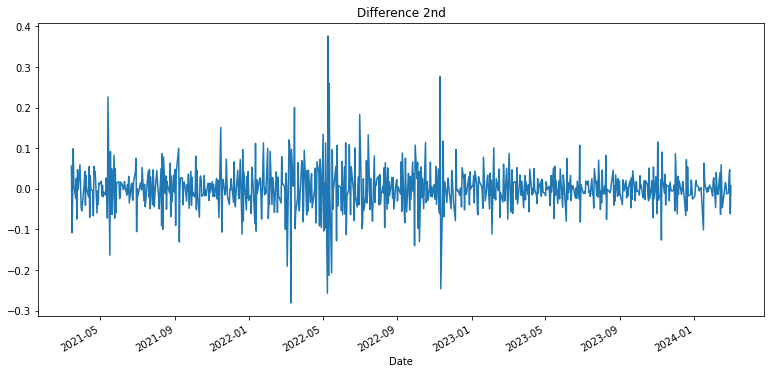

In [143]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

<AxesSubplot:title={'center':'Difference 2nd'}, xlabel='Date'>

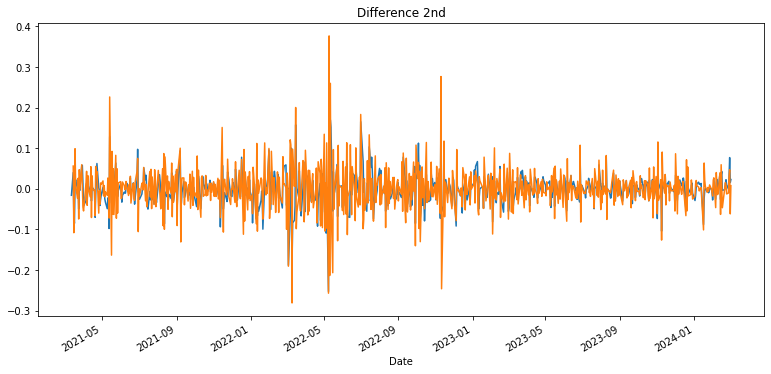

In [144]:
diff_1.plot(title='Difference 1st')
diff_2.plot(title='Difference 2nd')

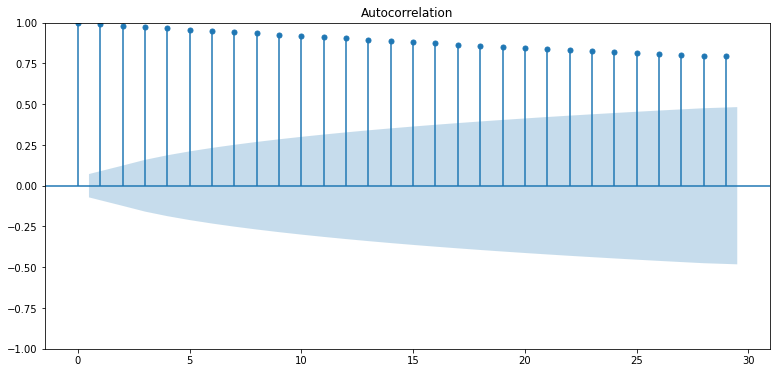

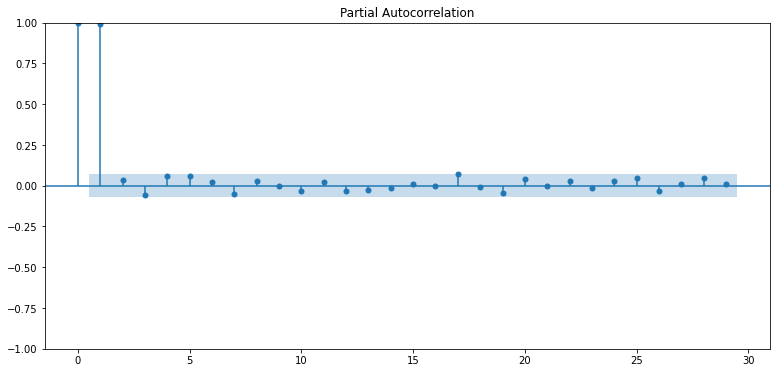

In [145]:
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

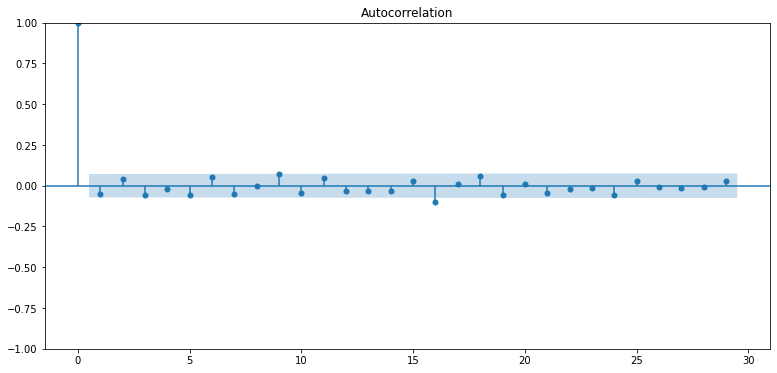

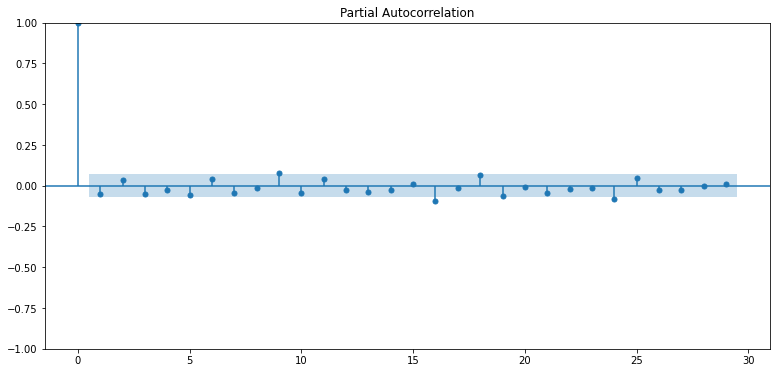

In [146]:
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

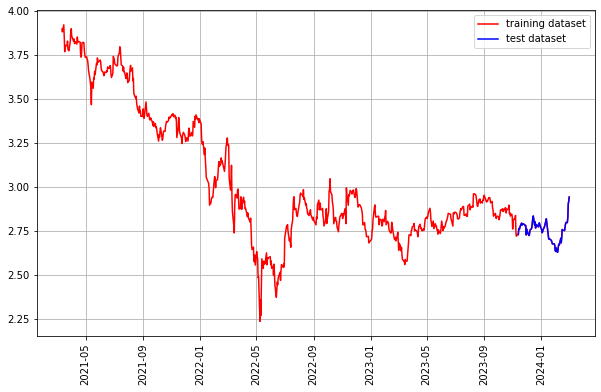

In [147]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.xticks(rotation=90)
plt.legend()

In [148]:
model = ARIMA(train_data, order=(0, 1, 12))  
fitted_m = model.fit() 

print(fitted_m.summary())

/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  674
Model:                ARIMA(0, 1, 12)   Log Likelihood                1228.827
Date:                Mon, 04 Mar 2024   AIC                          -2431.653
Time:                        01:18:15   BIC                          -2373.001
Sample:                             0   HQIC                         -2408.939
                                - 674                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0467      0.026     -1.819      0.069      -0.097       0.004
ma.L2          0.0280      0.033      0.846      0.398      -0.037       0.093
ma.L3         -0.0563      0.028     -2.017      0.0

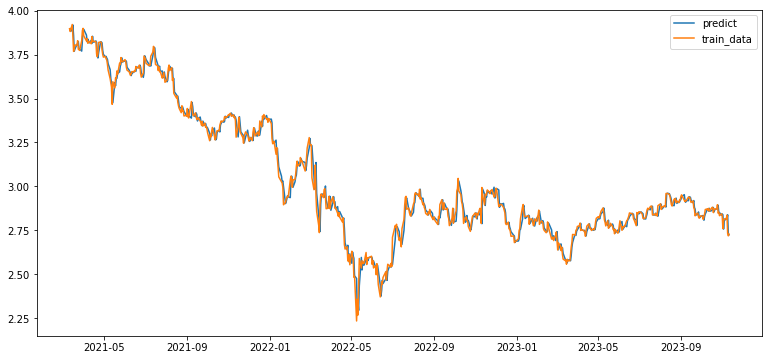

In [149]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

ma값을 넣어서 진행
p*q = 0 으로 진행

/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/woorethane/miniforge3/envs/study/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction r

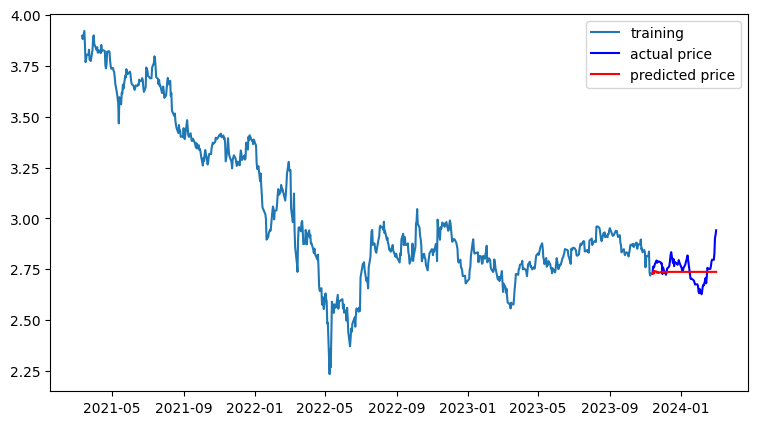

In [150]:
model = ARIMA(train_data, order=(0, 1, 12))  
fitted_m = model.fit()
fc = fitted_m.forecast(len(test_data), alpha=0.5) # 95% conf
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(9, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

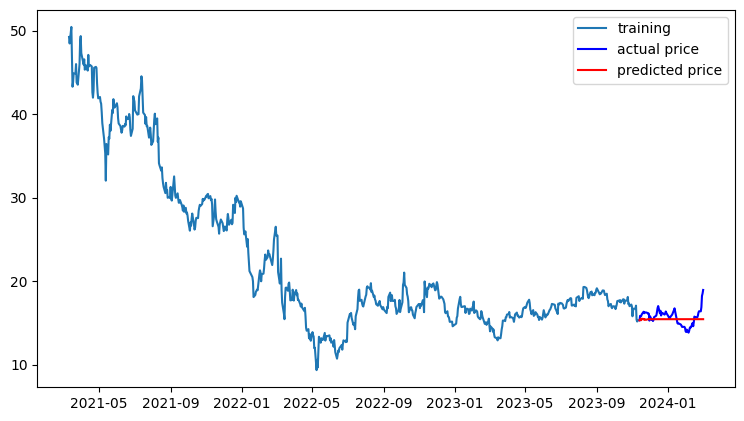

In [151]:
plt.figure(figsize=(9, 5), dpi=100)
plt.plot(np.exp(train_data), label='training')
plt.plot(np.exp(test_data), c='b', label='actual price')
plt.plot(np.exp(fc_series), c='r', label='predicted price')
plt.legend()
plt.show()

In [152]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1.0062569850481202
MAE:  0.787837647195474
RMSE:  1.0031236140417192
MAPE: 4.96%


### 회고

- 야후 파이낸스에서 제공하는 데이터를 최대치를 넣어 모델을 테스트 해보니 흥미로웠습니다.
- 하지만 p, q 적절한 값을 찾기에는 어려움이 많았습니다.
- 시계열에 대해서 많은 공부가 필요하다는 것을 느꼈습니다.
- ~~예측, 학습 데이터에 대한 그래프를 그리는데 학습데이터 값에서 횡방향으로 그어지는 문제가 발생했는데
해결을 하지 못해서 조금 아쉽습니다.~~
-> 데이터를 불러오고 날짜 시간을 변경 후 데이터프레임으로 작업을 진행했었는데 그 부분을 제거를 하니 문제가 해결 되었다.
- 더 다양한 데이터와 함께 학습을 한다면 조금 달라질 수 있겠지만, 주가를 예측하는 것은 어려워보인다
